# Artificial Neural Networks and Deep Learning

---

## Homework 1: Image classification




## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [ ]:
!pip install cleanvision

In [ ]:
pip install keras-cv --upgrade


In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

In [ ]:
!pip install --upgrade tensorflow keras keras-cv


In [ ]:
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
import keras_cv

# Set seeds for random number generators in NumPy, Python and Tensor Flow
np.random.seed(42)
tf.random.set_seed(42);
tf.compat.v1.set_random_seed(42);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.gridspec as gridspec
import cv2
from cleanvision import Imagelab

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## ⏳ Load the Data

In [ ]:
# Load the dataset
path_training_set="/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/training_set.npz"
data = np.load(path_training_set)
print(data.files)

X = data['images']  # Features (images)
y = data['labels']  # Labels

# inspect the dataset shape
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
# we have 13759 images (of size 96x96x3) with an associated label

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

## 🧹 CleanVision

It's a library that automatically detects various issues in the image data, such as images that are: (near) duplicates, blurry, over/under-exposed, etc. This data-centric AI package is designed as a quick first step for any computer vision project to find problems in the dataset.

In [ ]:
# create a temporary fold to save the images in .jpg
temp_folder = "/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/X_temp/"
if not os.path.exists(temp_folder):
    os.makedirs(temp_folder)

# Save each image in this temporary folder
for i, img in enumerate(X):
    img_path = os.path.join(temp_folder, f"image_{i}.jpg")  # save as jpg
    cv2.imwrite(img_path, img.astype(np.uint8))

In [ ]:
# temp_folder = "/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/X_temp/"

In [ ]:
# take the path of all the .jpg images in the folder
image_files = [os.path.join(temp_folder, f) for f in os.listdir(temp_folder) if f.endswith('.jpg')]

# Use Imagelab on that images
imagelab = Imagelab(filepaths=image_files)
imagelab.find_issues()
imagelab.report()

# It has identified 1816 duplicates in the dataset, divided in 10 folders.
# no other problems were found
# (the error is only a visualization error because there are too many images to plot)

In [ ]:
# print the number of sets of duplicates
imagelab.info["exact_duplicates"]["num_sets"]

In [ ]:
# Print the number of duplicated images for each set
duplicated_images = imagelab.info["exact_duplicates"]["sets"]
print(f"numebr of duplicated set: {len(duplicated_images)}")

for i, duplicate_set in enumerate(duplicated_images):
    print(f"Set {i}: contains {len(duplicate_set)} duplicated images")

In [ ]:
# just to check:
print(duplicated_images[9]) # last set contains only 2 elements

Remove the duplicated image

In [ ]:
# select duplicated images: i want to mantain only one image for set => i select the first one and discard the others
image_to_deleate = []  # List of images to deleate
image_to_maintain = []  # List of images to mantain

# (duplicated_images is a list of lists => images contains the duplicated_images for each set)
for images in duplicated_images:
    image_to_maintain.append(images[0])  # take only the first image of each set and add it to the list "image_to_mantain"

    # for the other images, add them to "image_to_deleate"
    for i in range(1, len(images)):
        image_to_deleate.append(images[i])

# print the 2 lists
print("Immagini da mantenere:", image_to_maintain)
print("Immagini da eliminare:", image_to_deleate)


In [ ]:
# check: the list "image to mantain" contains 10 elements as expected (1 for set)
print(len(image_to_maintain))

In [ ]:
# Print all the 10 images in "images_to_mantain"
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for i, img_path in enumerate(image_to_maintain):
    img = cv2.imread(img_path)

    # convert images from BGR (OpenCV) to RGB (matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # show the image on the i axis
    axes[i].imshow(img_rgb)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# As we can see, the first 2 images are mixup augmentation of a blood cell and a ”random” image taken from the web
# => we must remove also them from the dataset

In [ ]:
# In images_to_remove I have the path of the images, not their index.
# so I have to translate them in indixes in order to remove the corresponding images from the dataset

# list of index to remove
indices_to_remove = []

# path of the images
image_paths = [f"/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/X_temp/image_{i}.jpg" for i in range(len(X))]

# find indexes of images to remove
for idx, path in enumerate(image_paths):
    if path in image_to_deleate:
        indices_to_remove.append(idx)

print(len(indices_to_remove))

# to check:
# 1816-10 (1 per set) = 1806 => ok

In [ ]:
# Analyze the 'images_to_remove' target to assess whether their removal might lead to class imbalance.
print('Counting occurrences of target classes:')
print(pd.DataFrame(y[indices_to_remove], columns=['digit'])['digit'].value_counts())


In [ ]:
# Try to understand how the images in each set have been classified
# start for the test 0 and then change the set
image_to_deleate_0 = []  # list of images_to_deleate set0
image_to_maintain_0 = []  # list of images_to_ mantain set0

image_to_maintain_0=duplicated_images[0][0] # take only the first image of the set

for image in (duplicated_images[0]): # add all the others to image-to_deleate set0
    image_to_deleate_0.append(image)

# print results
print("Immagini da mantenere:", image_to_maintain_0)
print("Immagini da eliminare:", image_to_deleate_0)

image_paths = [f"/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/X_temp/image_{i}.jpg" for i in range(len(X))]

indices_to_remove_0 = [] # list of indixes to remove

for idx, path in enumerate(image_paths): # find indixes of image to remove
    if path in image_to_deleate_0:
        indices_to_remove_0.append(idx)

print(len(indices_to_remove_0))


# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y[indices_to_remove_0], columns=['digit'])['digit'].value_counts())

# the 1600 images of the set 0, are equally classified => no problem of class unbalance
# The 1600 images in the set 0 are evenly distributed across the 8 classes, with 200 images per class => no class imbalance
# the 200 images of the set 1 are all classified as class 5
# all the other 8 images are classified in ≠ classes
# => ok, no evident problems in class imbalance

Now I add also the 2 images of the first 2 sets (the ones with MIxUp) to the list of image to remove.

In [ ]:
print(image_to_maintain[0]) # print to read the indixes
print(image_to_maintain[1])
indices_to_remove.append(12759) # add both to the list to remove
indices_to_remove.append(13559)

In [ ]:
# just to check: print the length of "indices_to_remove"
print(len(indices_to_remove))
# 1816-8 =1808 => ok

In [ ]:
# REMOVE DUPLICATED IMAGES
# Deleate duplicated images and the corresponded labels.

indices_to_remove.sort(reverse=True)
X_new = np.delete(X, indices_to_remove, axis=0)
y_new = np.delete(y, indices_to_remove, axis=0)

print(f"Numero di immagini dopo la rimozione: {len(X_new)}")

In [ ]:
# Save the new dataset
save_path = "/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/images_new2.npz"
np.savez(save_path, X_new=X_new, y_new=y_new) # save as .npz
print(f"X_new e y_new salvati in: {save_path}")

Load pre-processed data

In [ ]:
# Load X_new e y_new from the file .npz
data = np.load("/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/images_new2.npz")

X = data['X_new']
y = data['y_new']

print(f"X_new caricato con {X.shape[0]} immagini")
print(f"y_new caricato con {y.shape[0]} labels")

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

## 🔎 Inspect dataset

In [ ]:
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}
unique_labels = list(labels.values())
unique_labels

In [ ]:
# TRAIN - TEST SPLIT
# Split the data into training and validation sets (80% train, 20% val/test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("validation Data Shape:", X_val.shape)
print("validation Label Shape:", y_val.shape)

In [ ]:
# DISPLAY SOME EXAMPLES
# Display a sample of images from the training dataset
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🔧 Prepare dataset

 I transform both the training and the validation sets in dictionaries, containing both the images and the labels. This is required in order to apply augmentations that modify also the labels (ex: MixUp, CutMix).

In [ ]:
NUM_CLASSES = 8   # n of classes
BATCH_SIZE = 32   # divide in batch sizes

# transform in a dictionary and change the labels in one-hot-encoded
def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


# put X_train and y_train in a dictionary "train_ds"
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda image, label: package_inputs(image, label), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 16) #  mescoliamo i dati (shuffle)

# put X_val and y_val in a dictionary "val_ds"
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(lambda image, label:package_inputs(image, label), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)# create batch

In [ ]:
for batch in train_ds.take(1):  # take a batch as example
    print(batch["images"].shape)
    print(batch["labels"].shape)

# images: (BATCH_SIZE, Height, Width, Channel)
# labels: (BATCH_SIZE, NUM_CLASSES)

In [ ]:
# Print examples
batch = next(iter(train_ds.take(1)))
label_batch = batch["labels"]
image_batch = batch["images"].numpy()

keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)


## 🎨 Augmentation

**1) Random Flip:**
Flips the image horizontally or vertically to create mirror images. Help the model to generalize better to different orientations.

In [ ]:
#RANDOM FLIP
random_flip = keras_cv.layers.RandomFlip(seed=42)
augmenters = [random_flip] # add random_flip to the pipeline of augmentation

# print examples
image_batch = random_flip(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

**2) Rand_Augment:** Applies a set of randomly chosen augmentation transformations from a predefined list (rotation, shear, translation, brightness, contrast, color, sharpness, posterize, solarize, autocontrast, equalize, invert) with a fixed number of transformations and magnitude.
This method enhances image diversity and reduces the risk of overfitting by introducing random variations.

In [ ]:
# RAND_AUGMENT

rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,  # apply 3 of the possible augmentation for each image
    value_range=(0, 255),
    magnitude=0.3,  # apply augmentations with a magnitude of 0.3
    magnitude_stddev=0.2, # and a standard deviation of 0.2
    rate=0.8, # apply Rand_augment to 80% of the images
    seed=42,
)
augmenters += [rand_augment] # add rand_augment to the pipeline of augmentation

# print examples
image_batch = rand_augment(image_batch)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

**3) Random_cutout:** removes a random square or rectangular region from the image, replacing it with a constant value (usually black). This forces the model to rely on surrounding context and other features, improving its robustness to occluded parts.

In [ ]:
# RANDOM_CUTOUT
random_cutout = keras_cv.layers.RandomCutout(width_factor=0.4, height_factor=0.4, seed=42)

# print examples
keras_cv.visualization.plot_image_gallery(
    random_cutout(image_batch),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

**4) CutMix:** combines two training images  by cutting a rectangular patch from one image and pasting it onto another. The model is trained on the mixed image, and the labels are proportionally mixed based on the area of the patch => the model  generalize better

In [ ]:
# CUTMIX
cut_mix = keras_cv.layers.CutMix(seed=42)

# CutMix needs as input both images and labels in a tensorflow format

# Convert numpy array in tensor of TensorFlow
image_batch = tf.convert_to_tensor(image_batch)
label_batch = tf.convert_to_tensor(label_batch)
inputs = {"images": image_batch, "labels": label_batch}

# print examples
keras_cv.visualization.plot_image_gallery(
    cut_mix(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

**5) MixUp:** combines two images  by taking a weighted average of their pixel values and their corresponding labels. It results in a new image that is a blend of both inputs => prevents the model from overfitting to specific patterns in the training data.

In [ ]:
# MIXUP
mix_up = keras_cv.layers.MixUp(seed=42)

# MixUp needs as input both images and labels in a tensorflow format
inputs = {"images": image_batch, "labels": label_batch}

# print examples
keras_cv.visualization.plot_image_gallery(
    mix_up(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [ ]:
# to apply to some batches cut mix and to other mix up
cut_mix_or_mix_up = keras_cv.layers.RandomChoice([cut_mix, mix_up],seed=42, batchwise=True)
augmenters += [cut_mix_or_mix_up]

**=>** now that the Augmentation pipeline is done, we can apply it to train_ds

In [ ]:
# AUGMENTATION

def create_augmenter_fn(augmenters): # take all the augmentations in the pipeline...
    def augmenter_fn(inputs): # ... and apply each of them in sequence to the input
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenter_fn

# apply augmentation to train_ds
# augmenters is a list of functions that apply transformations
augmenter_fn = create_augmenter_fn(augmenters) # create the function of Augmentation based on "augmenters"
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE) # applies the function to train_ds

# print examples
image_batch = next(iter(train_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [ ]:
# check the shape of train_ds
print(train_ds.element_spec)

In [ ]:
# function of label preprocessing (they are in the format 32x32x8, but i want them in 32x1x8)
# (32x32x8): - 32: is the number of elements in each batch;
#            - 32: due to applying mixup/CutMix augmentations, each image in the batch has been mixed with another,
#                 resulting in 32 labels for each image. These label vectors are not one-hot-encoded, but only hot-encoded
#                 meaning that there are continuous values btw 0 and 1, representing the probability to belong to each class
#            - 8 is the number of elements in this vector (the 8 classes)

def preprocess_labels(batch): # sum along the axis 1 (I sum the probabilities to belong to each class)
                              # => from (None, None, 8) to (None, 1, 8)
    labels = batch['labels'] # extract a label from the batch
    labels_reduced = tf.reduce_sum(labels, axis=1, keepdims=False) # collapse the 32 "mixup" labels into a single one

    # now each element in the batch has 1 vector that corresponds to the class scores.
    # we find the index of the class with the highest value (most dominant class)
    indices = tf.argmax(labels_reduced, axis=1)  # (None,) --> one index for image

    # transform in one-hot (with shape (None, 8))
    labels_one_hot = tf.one_hot(indices, depth=8, axis=-1)  # (None, 8)

    # update the disctionary with the new labels
    batch['labels'] = labels_one_hot
    return batch

# apply the label pre-processing function to train_ds
train_ds = train_ds.map(preprocess_labels, num_parallel_calls=tf.data.AUTOTUNE)

# check new shape
for batch in train_ds.take(1):
    print(batch['images'].shape)  # (None, 96, 96, 3)
    print(batch['labels'].shape)  # (None, 8) => ok


In [ ]:
# transform train_ds from a dictionary to a tupla (the model want a tupla as input)
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)  # apply unpackage_dict to train_ds

In [ ]:
# check the shape of train_ds
print(train_ds.element_spec)

In [ ]:
# check the shape of val_ds
print(val_ds.element_spec)

In [ ]:
# RESIZE
# Xceptionet takes as input images of shape 299x299
def resize_image(image, label):
    image = tf.image.resize(image, (299, 299))  # reshape
    return image, label

train_ds = train_ds.map(resize_image) # reshape train_ds
val_ds = val_ds.map(lambda x: resize_image(x['images'], x['labels']), num_parallel_calls=tf.data.AUTOTUNE) # reshape val_ds

In [ ]:
# NORMALIZATION
# depending on the model we used, we applied ≠ types of normalization
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # normalize train_ds
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # normalize val_ds

In [ ]:
# val_ds hasn't batch now, but i want the same structure of train_ds
# => create batch in val_ds
val_ds = val_ds.batch(BATCH_SIZE)

In [ ]:
# val_ds shape is (32x1x8), but i want (32x8) => remove extra dimension
def reshape_labels(images, labels):
    labels = tf.squeeze(labels, axis=1)  # Rimuove la dimensione 1 dai labels
    return images, labels

val_ds = val_ds.map(lambda x, y: reshape_labels(x, y), num_parallel_calls=tf.data.AUTOTUNE) # reshape vaL_ds

Since we have seen that the dataset is quite unbalanced we decided to calculate class weights to be multiplied to the loss function. In the training, the model will give more importance to the errors coming from samples that are weighted more, that are those belonging to less represented classes.

In [ ]:
counts = tf.zeros((8,), dtype=tf.float32) #initialize the counts variable
for batch in train_ds: #for batch
  counts += tf.reduce_sum(batch[1], axis=0) #sum the appearances for each class

total = tf.reduce_sum(counts) #calculate the total of the samples

In [ ]:
total = total.numpy() #reduce to a scalar
total

In [ ]:
#each class weight is the total of the samples divided by the number of samples for that class
class_weights = {
    0: total/counts[0].numpy(),
    1: total/counts[1].numpy(),
    2: total/counts[2].numpy(),
    3: total/counts[3].numpy(),
    4: total/counts[4].numpy(),
    5: total/counts[5].numpy(),
    6: total/counts[6].numpy(),
    7: total/counts[7].numpy()
}

In [ ]:
'''Normalization of the weights was performed to ensure their mean equals 1. This choice was made to prevent altering the total error
when the weights are applied to the loss, maintaining consistency in the overall scale of the error.'''
normalized_class_weights = {k: v / np.mean(np.asarray(list(class_weights.values()))) for k, v in class_weights.items()}
normalized_class_weights

## 🔄 Model Training

We have test different models: VGG16, Xception, EfficientNetB7, ResNet101. The pipeline is the same, changes only the pre-processing needed (resize, normalization) and the pre-trained model that is imported.

Extraction of input and output shape to build the model

In [ ]:
# Input shape for the model
#input_shape = X_train.shape[1:]
input_shape = (299,299,3)   # it changes depending on the model

# Output shape for the model
y_train = tfk.utils.to_categorical(y_train)
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

In [ ]:
# Number of training epochs
epochs = 150

# Batch size for training
batch_size = 16

# Learning rate: step size for updating the model's weights
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,    # initial learning rate
    decay_steps=5000,         # number of steps in which the decay is applied
    decay_rate=0.7,           # decay factor
    staircase=True            # staircase decay
)

In [ ]:
%cd https://www.youtube.com/watch?v=dQw4w9WgXcQ #insert the path in which you want to save the model weights

In [ ]:
# Define the patience value for early stopping
patience = 15 #configs['earlystopping_patience']

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

### basic CNN (5 convolutional layer)

In [ ]:
seed=42
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=lr_schedule,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    # Apply activation and pooling after the first convolution
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Apply third convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    # Apply fourth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    # Apply fifth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.Flatten(name='flatten')(x)

    # Define the output layer with softmax activation for classification
    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    #loss = tfk.losses.CategoricalCrossentropy()
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)   # smoothing to prevent overfitting due to MixUp e CutMix
    #optimizer = tfk.optimizers.Adam(learning_rate)
    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

In [ ]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model with early stopping callback
#model.fit(augmented_data['images'], augmented_data['labels'], epochs=10, batch_size=32)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

del model

In [ ]:
Epoch 1/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - categorical_accuracy: 0.1794 - loss: 2.0373 - top_k_categorical_accuracy: 0.7526 - val_categorical_accuracy: 0.1957 - val_loss: 2.0094 - val_top_k_categorical_accuracy: 0.7595
Epoch 2/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - categorical_accuracy: 0.1950 - loss: 2.0142 - top_k_categorical_accuracy: 0.7833 - val_categorical_accuracy: 0.1957 - val_loss: 1.9880 - val_top_k_categorical_accuracy: 0.7595
Epoch 3/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.1968 - loss: 2.0081 - top_k_categorical_accuracy: 0.7808 - val_categorical_accuracy: 0.3003 - val_loss: 1.9503 - val_top_k_categorical_accuracy: 0.8223
Epoch 4/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.2312 - loss: 1.9957 - top_k_categorical_accuracy: 0.7894 - val_categorical_accuracy: 0.4145 - val_loss: 1.8473 - val_top_k_categorical_accuracy: 0.9009
Epoch 5/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.2434 - loss: 1.9765 - top_k_categorical_accuracy: 0.8029 - val_categorical_accuracy: 0.3300 - val_loss: 1.8007 - val_top_k_categorical_accuracy: 0.9628
Epoch 6/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.2453 - loss: 1.9632 - top_k_categorical_accuracy: 0.8099 - val_categorical_accuracy: 0.4417 - val_loss: 1.7067 - val_top_k_categorical_accuracy: 0.9808
Epoch 7/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.2503 - loss: 1.9609 - top_k_categorical_accuracy: 0.8189 - val_categorical_accuracy: 0.5362 - val_loss: 1.6577 - val_top_k_categorical_accuracy: 0.9808
Epoch 8/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.2613 - loss: 1.9514 - top_k_categorical_accuracy: 0.8212 - val_categorical_accuracy: 0.4613 - val_loss: 1.6241 - val_top_k_categorical_accuracy: 0.9829
Epoch 9/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.2632 - loss: 1.9467 - top_k_categorical_accuracy: 0.8270 - val_categorical_accuracy: 0.5437 - val_loss: 1.5505 - val_top_k_categorical_accuracy: 0.9833
Epoch 10/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.2774 - loss: 1.9303 - top_k_categorical_accuracy: 0.8296 - val_categorical_accuracy: 0.6064 - val_loss: 1.6008 - val_top_k_categorical_accuracy: 0.9778
Epoch 11/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.2935 - loss: 1.9189 - top_k_categorical_accuracy: 0.8306 - val_categorical_accuracy: 0.6290 - val_loss: 1.5269 - val_top_k_categorical_accuracy: 0.9787
Epoch 12/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.2973 - loss: 1.9057 - top_k_categorical_accuracy: 0.8408 - val_categorical_accuracy: 0.6386 - val_loss: 1.5089 - val_top_k_categorical_accuracy: 0.9808
Epoch 13/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.2987 - loss: 1.9106 - top_k_categorical_accuracy: 0.8323 - val_categorical_accuracy: 0.6713 - val_loss: 1.4271 - val_top_k_categorical_accuracy: 0.9808
Epoch 14/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.3129 - loss: 1.8872 - top_k_categorical_accuracy: 0.8510 - val_categorical_accuracy: 0.6320 - val_loss: 1.4237 - val_top_k_categorical_accuracy: 0.9816
Epoch 15/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.3232 - loss: 1.8820 - top_k_categorical_accuracy: 0.8436 - val_categorical_accuracy: 0.5847 - val_loss: 1.3736 - val_top_k_categorical_accuracy: 0.9824
Epoch 16/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.3220 - loss: 1.8831 - top_k_categorical_accuracy: 0.8411 - val_categorical_accuracy: 0.5893 - val_loss: 1.3891 - val_top_k_categorical_accuracy: 0.9833
Epoch 17/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3383 - loss: 1.8681 - top_k_categorical_accuracy: 0.8456 - val_categorical_accuracy: 0.6939 - val_loss: 1.3304 - val_top_k_categorical_accuracy: 0.9849
Epoch 18/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.3411 - loss: 1.8540 - top_k_categorical_accuracy: 0.8601 - val_categorical_accuracy: 0.6834 - val_loss: 1.3287 - val_top_k_categorical_accuracy: 0.9875
Epoch 19/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3519 - loss: 1.8445 - top_k_categorical_accuracy: 0.8601 - val_categorical_accuracy: 0.7240 - val_loss: 1.2784 - val_top_k_categorical_accuracy: 0.9820
Epoch 20/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3475 - loss: 1.8581 - top_k_categorical_accuracy: 0.8496 - val_categorical_accuracy: 0.6855 - val_loss: 1.3236 - val_top_k_categorical_accuracy: 0.9837
Epoch 21/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3579 - loss: 1.8424 - top_k_categorical_accuracy: 0.8561 - val_categorical_accuracy: 0.7340 - val_loss: 1.2989 - val_top_k_categorical_accuracy: 0.9833
Epoch 22/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3551 - loss: 1.8465 - top_k_categorical_accuracy: 0.8551 - val_categorical_accuracy: 0.7762 - val_loss: 1.2221 - val_top_k_categorical_accuracy: 0.9891
Epoch 23/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.3553 - loss: 1.8440 - top_k_categorical_accuracy: 0.8542 - val_categorical_accuracy: 0.7650 - val_loss: 1.2256 - val_top_k_categorical_accuracy: 0.9879
Epoch 24/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.3678 - loss: 1.8242 - top_k_categorical_accuracy: 0.8522 - val_categorical_accuracy: 0.7712 - val_loss: 1.1646 - val_top_k_categorical_accuracy: 0.9925
Epoch 25/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3789 - loss: 1.8187 - top_k_categorical_accuracy: 0.8578 - val_categorical_accuracy: 0.7353 - val_loss: 1.1493 - val_top_k_categorical_accuracy: 0.9946
Epoch 26/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.3821 - loss: 1.8148 - top_k_categorical_accuracy: 0.8594 - val_categorical_accuracy: 0.7875 - val_loss: 1.1492 - val_top_k_categorical_accuracy: 0.9941
Epoch 27/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.3893 - loss: 1.8079 - top_k_categorical_accuracy: 0.8592 - val_categorical_accuracy: 0.7566 - val_loss: 1.1954 - val_top_k_categorical_accuracy: 0.9946
Epoch 28/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.3872 - loss: 1.8067 - top_k_categorical_accuracy: 0.8564 - val_categorical_accuracy: 0.7854 - val_loss: 1.1288 - val_top_k_categorical_accuracy: 0.9908
Epoch 29/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.3958 - loss: 1.7936 - top_k_categorical_accuracy: 0.8601 - val_categorical_accuracy: 0.8080 - val_loss: 1.1297 - val_top_k_categorical_accuracy: 0.9946
Epoch 30/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.3971 - loss: 1.7957 - top_k_categorical_accuracy: 0.8621 - val_categorical_accuracy: 0.7880 - val_loss: 1.1507 - val_top_k_categorical_accuracy: 0.9929
Epoch 31/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4004 - loss: 1.7847 - top_k_categorical_accuracy: 0.8631 - val_categorical_accuracy: 0.8068 - val_loss: 1.0723 - val_top_k_categorical_accuracy: 0.9929
Epoch 32/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4135 - loss: 1.7703 - top_k_categorical_accuracy: 0.8658 - val_categorical_accuracy: 0.8076 - val_loss: 1.0409 - val_top_k_categorical_accuracy: 0.9950
Epoch 33/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.3974 - loss: 1.7895 - top_k_categorical_accuracy: 0.8648 - val_categorical_accuracy: 0.8156 - val_loss: 1.0395 - val_top_k_categorical_accuracy: 0.9958
Epoch 34/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4119 - loss: 1.7853 - top_k_categorical_accuracy: 0.8588 - val_categorical_accuracy: 0.8331 - val_loss: 1.0512 - val_top_k_categorical_accuracy: 0.9967
Epoch 35/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4100 - loss: 1.7783 - top_k_categorical_accuracy: 0.8646 - val_categorical_accuracy: 0.8289 - val_loss: 1.0275 - val_top_k_categorical_accuracy: 0.9971
Epoch 36/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4109 - loss: 1.7791 - top_k_categorical_accuracy: 0.8596 - val_categorical_accuracy: 0.8315 - val_loss: 1.0146 - val_top_k_categorical_accuracy: 0.9941
Epoch 37/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4166 - loss: 1.7741 - top_k_categorical_accuracy: 0.8642 - val_categorical_accuracy: 0.8122 - val_loss: 1.0202 - val_top_k_categorical_accuracy: 0.9958
Epoch 38/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4153 - loss: 1.7646 - top_k_categorical_accuracy: 0.8700 - val_categorical_accuracy: 0.8151 - val_loss: 1.0102 - val_top_k_categorical_accuracy: 0.9946
Epoch 39/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4191 - loss: 1.7607 - top_k_categorical_accuracy: 0.8721 - val_categorical_accuracy: 0.8269 - val_loss: 0.9887 - val_top_k_categorical_accuracy: 0.9958
Epoch 40/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4125 - loss: 1.7711 - top_k_categorical_accuracy: 0.8597 - val_categorical_accuracy: 0.8356 - val_loss: 0.9993 - val_top_k_categorical_accuracy: 0.9962
Epoch 41/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4249 - loss: 1.7584 - top_k_categorical_accuracy: 0.8678 - val_categorical_accuracy: 0.8022 - val_loss: 1.0435 - val_top_k_categorical_accuracy: 0.9921
Epoch 42/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4208 - loss: 1.7485 - top_k_categorical_accuracy: 0.8689 - val_categorical_accuracy: 0.8256 - val_loss: 0.9714 - val_top_k_categorical_accuracy: 0.9971
Epoch 43/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4210 - loss: 1.7552 - top_k_categorical_accuracy: 0.8754 - val_categorical_accuracy: 0.8369 - val_loss: 0.9966 - val_top_k_categorical_accuracy: 0.9912
Epoch 44/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4369 - loss: 1.7404 - top_k_categorical_accuracy: 0.8724 - val_categorical_accuracy: 0.8264 - val_loss: 1.0124 - val_top_k_categorical_accuracy: 0.9895
Epoch 45/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4336 - loss: 1.7565 - top_k_categorical_accuracy: 0.8669 - val_categorical_accuracy: 0.8473 - val_loss: 0.9805 - val_top_k_categorical_accuracy: 0.9946
Epoch 46/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4398 - loss: 1.7372 - top_k_categorical_accuracy: 0.8750 - val_categorical_accuracy: 0.8478 - val_loss: 0.9861 - val_top_k_categorical_accuracy: 0.9941
Epoch 47/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4397 - loss: 1.7367 - top_k_categorical_accuracy: 0.8748 - val_categorical_accuracy: 0.8457 - val_loss: 0.9829 - val_top_k_categorical_accuracy: 0.9929
Epoch 48/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4362 - loss: 1.7342 - top_k_categorical_accuracy: 0.8731 - val_categorical_accuracy: 0.8565 - val_loss: 0.9449 - val_top_k_categorical_accuracy: 0.9958
Epoch 49/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4382 - loss: 1.7377 - top_k_categorical_accuracy: 0.8723 - val_categorical_accuracy: 0.8340 - val_loss: 0.9854 - val_top_k_categorical_accuracy: 0.9941
Epoch 50/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4378 - loss: 1.7392 - top_k_categorical_accuracy: 0.8774 - val_categorical_accuracy: 0.8306 - val_loss: 0.9632 - val_top_k_categorical_accuracy: 0.9933
Epoch 51/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4459 - loss: 1.7314 - top_k_categorical_accuracy: 0.8716 - val_categorical_accuracy: 0.8582 - val_loss: 0.9409 - val_top_k_categorical_accuracy: 0.9941
Epoch 52/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4351 - loss: 1.7323 - top_k_categorical_accuracy: 0.8730 - val_categorical_accuracy: 0.8628 - val_loss: 0.9377 - val_top_k_categorical_accuracy: 0.9941
Epoch 53/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4486 - loss: 1.7315 - top_k_categorical_accuracy: 0.8707 - val_categorical_accuracy: 0.8532 - val_loss: 0.9593 - val_top_k_categorical_accuracy: 0.9958
Epoch 54/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4544 - loss: 1.7115 - top_k_categorical_accuracy: 0.8761 - val_categorical_accuracy: 0.8557 - val_loss: 0.9537 - val_top_k_categorical_accuracy: 0.9946
Epoch 55/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4457 - loss: 1.7153 - top_k_categorical_accuracy: 0.8787 - val_categorical_accuracy: 0.8532 - val_loss: 0.9788 - val_top_k_categorical_accuracy: 0.9933
Epoch 56/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4441 - loss: 1.7239 - top_k_categorical_accuracy: 0.8712 - val_categorical_accuracy: 0.8511 - val_loss: 0.9745 - val_top_k_categorical_accuracy: 0.9925
Epoch 57/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4496 - loss: 1.7322 - top_k_categorical_accuracy: 0.8658 - val_categorical_accuracy: 0.8649 - val_loss: 0.9355 - val_top_k_categorical_accuracy: 0.9962
Epoch 58/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4472 - loss: 1.7223 - top_k_categorical_accuracy: 0.8772 - val_categorical_accuracy: 0.8574 - val_loss: 0.9559 - val_top_k_categorical_accuracy: 0.9941
Epoch 59/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4571 - loss: 1.7094 - top_k_categorical_accuracy: 0.8787 - val_categorical_accuracy: 0.8649 - val_loss: 0.9387 - val_top_k_categorical_accuracy: 0.9954
Epoch 60/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - categorical_accuracy: 0.4589 - loss: 1.7119 - top_k_categorical_accuracy: 0.8774 - val_categorical_accuracy: 0.8369 - val_loss: 0.9754 - val_top_k_categorical_accuracy: 0.9933
Epoch 61/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - categorical_accuracy: 0.4438 - loss: 1.7290 - top_k_categorical_accuracy: 0.8762 - val_categorical_accuracy: 0.8683 - val_loss: 0.9602 - val_top_k_categorical_accuracy: 0.9950
Epoch 62/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4560 - loss: 1.7149 - top_k_categorical_accuracy: 0.8759 - val_categorical_accuracy: 0.8695 - val_loss: 0.9442 - val_top_k_categorical_accuracy: 0.9971
Epoch 63/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4357 - loss: 1.7319 - top_k_categorical_accuracy: 0.8741 - val_categorical_accuracy: 0.8683 - val_loss: 0.9747 - val_top_k_categorical_accuracy: 0.9954
Epoch 64/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4538 - loss: 1.7152 - top_k_categorical_accuracy: 0.8729 - val_categorical_accuracy: 0.8578 - val_loss: 0.9219 - val_top_k_categorical_accuracy: 0.9954
Epoch 65/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4481 - loss: 1.7102 - top_k_categorical_accuracy: 0.8774 - val_categorical_accuracy: 0.8762 - val_loss: 0.9570 - val_top_k_categorical_accuracy: 0.9937
Epoch 66/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4439 - loss: 1.7311 - top_k_categorical_accuracy: 0.8755 - val_categorical_accuracy: 0.8695 - val_loss: 0.9441 - val_top_k_categorical_accuracy: 0.9946
Epoch 67/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4574 - loss: 1.7094 - top_k_categorical_accuracy: 0.8738 - val_categorical_accuracy: 0.8754 - val_loss: 0.9300 - val_top_k_categorical_accuracy: 0.9954
Epoch 68/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4624 - loss: 1.7066 - top_k_categorical_accuracy: 0.8847 - val_categorical_accuracy: 0.8875 - val_loss: 0.9048 - val_top_k_categorical_accuracy: 0.9958
Epoch 69/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4616 - loss: 1.7175 - top_k_categorical_accuracy: 0.8666 - val_categorical_accuracy: 0.8779 - val_loss: 0.9183 - val_top_k_categorical_accuracy: 0.9937
Epoch 70/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4592 - loss: 1.7002 - top_k_categorical_accuracy: 0.8812 - val_categorical_accuracy: 0.8795 - val_loss: 0.9267 - val_top_k_categorical_accuracy: 0.9962
Epoch 71/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4568 - loss: 1.7198 - top_k_categorical_accuracy: 0.8734 - val_categorical_accuracy: 0.8821 - val_loss: 0.9303 - val_top_k_categorical_accuracy: 0.9946
Epoch 72/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4427 - loss: 1.7133 - top_k_categorical_accuracy: 0.8786 - val_categorical_accuracy: 0.8846 - val_loss: 0.8894 - val_top_k_categorical_accuracy: 0.9958
Epoch 73/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4564 - loss: 1.7075 - top_k_categorical_accuracy: 0.8783 - val_categorical_accuracy: 0.8737 - val_loss: 0.9192 - val_top_k_categorical_accuracy: 0.9946
Epoch 74/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - categorical_accuracy: 0.4603 - loss: 1.7069 - top_k_categorical_accuracy: 0.8715 - val_categorical_accuracy: 0.8850 - val_loss: 0.9070 - val_top_k_categorical_accuracy: 0.9950
Epoch 75/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4603 - loss: 1.7079 - top_k_categorical_accuracy: 0.8763 - val_categorical_accuracy: 0.8921 - val_loss: 0.8958 - val_top_k_categorical_accuracy: 0.9950
Epoch 76/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4595 - loss: 1.7075 - top_k_categorical_accuracy: 0.8791 - val_categorical_accuracy: 0.8812 - val_loss: 0.9298 - val_top_k_categorical_accuracy: 0.9958
Epoch 77/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4551 - loss: 1.7026 - top_k_categorical_accuracy: 0.8812 - val_categorical_accuracy: 0.8892 - val_loss: 0.8821 - val_top_k_categorical_accuracy: 0.9958
Epoch 78/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4711 - loss: 1.6838 - top_k_categorical_accuracy: 0.8858 - val_categorical_accuracy: 0.8791 - val_loss: 0.9340 - val_top_k_categorical_accuracy: 0.9958
Epoch 79/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4684 - loss: 1.6897 - top_k_categorical_accuracy: 0.8878 - val_categorical_accuracy: 0.8712 - val_loss: 0.9639 - val_top_k_categorical_accuracy: 0.9937
Epoch 80/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4629 - loss: 1.6900 - top_k_categorical_accuracy: 0.8862 - val_categorical_accuracy: 0.8741 - val_loss: 0.9430 - val_top_k_categorical_accuracy: 0.9950
Epoch 81/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4632 - loss: 1.6981 - top_k_categorical_accuracy: 0.8870 - val_categorical_accuracy: 0.8833 - val_loss: 0.9275 - val_top_k_categorical_accuracy: 0.9954
Epoch 82/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4664 - loss: 1.6916 - top_k_categorical_accuracy: 0.8809 - val_categorical_accuracy: 0.8821 - val_loss: 0.9266 - val_top_k_categorical_accuracy: 0.9967
Epoch 83/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4549 - loss: 1.7076 - top_k_categorical_accuracy: 0.8839 - val_categorical_accuracy: 0.8892 - val_loss: 0.8577 - val_top_k_categorical_accuracy: 0.9950
Epoch 84/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4724 - loss: 1.6961 - top_k_categorical_accuracy: 0.8819 - val_categorical_accuracy: 0.8883 - val_loss: 0.9089 - val_top_k_categorical_accuracy: 0.9967
Epoch 85/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4609 - loss: 1.7040 - top_k_categorical_accuracy: 0.8903 - val_categorical_accuracy: 0.8875 - val_loss: 0.9133 - val_top_k_categorical_accuracy: 0.9958
Epoch 86/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4675 - loss: 1.6878 - top_k_categorical_accuracy: 0.8833 - val_categorical_accuracy: 0.8883 - val_loss: 0.8976 - val_top_k_categorical_accuracy: 0.9971
Epoch 87/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4607 - loss: 1.7126 - top_k_categorical_accuracy: 0.8781 - val_categorical_accuracy: 0.8825 - val_loss: 0.9016 - val_top_k_categorical_accuracy: 0.9950
Epoch 88/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4670 - loss: 1.6940 - top_k_categorical_accuracy: 0.8752 - val_categorical_accuracy: 0.8992 - val_loss: 0.8622 - val_top_k_categorical_accuracy: 0.9958
Epoch 89/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4586 - loss: 1.7036 - top_k_categorical_accuracy: 0.8764 - val_categorical_accuracy: 0.8846 - val_loss: 0.8938 - val_top_k_categorical_accuracy: 0.9967
Epoch 90/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4607 - loss: 1.6975 - top_k_categorical_accuracy: 0.8826 - val_categorical_accuracy: 0.8892 - val_loss: 0.9091 - val_top_k_categorical_accuracy: 0.9958
Epoch 91/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4773 - loss: 1.6819 - top_k_categorical_accuracy: 0.8786 - val_categorical_accuracy: 0.8896 - val_loss: 0.8964 - val_top_k_categorical_accuracy: 0.9962
Epoch 92/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4636 - loss: 1.6958 - top_k_categorical_accuracy: 0.8853 - val_categorical_accuracy: 0.8971 - val_loss: 0.8647 - val_top_k_categorical_accuracy: 0.9962
Epoch 93/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - categorical_accuracy: 0.4585 - loss: 1.7010 - top_k_categorical_accuracy: 0.8812 - val_categorical_accuracy: 0.8946 - val_loss: 0.8853 - val_top_k_categorical_accuracy: 0.9958
Epoch 94/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - categorical_accuracy: 0.4721 - loss: 1.6805 - top_k_categorical_accuracy: 0.8910 - val_categorical_accuracy: 0.8984 - val_loss: 0.8736 - val_top_k_categorical_accuracy: 0.9958
Epoch 95/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - categorical_accuracy: 0.4698 - loss: 1.6964 - top_k_categorical_accuracy: 0.8769 - val_categorical_accuracy: 0.8967 - val_loss: 0.8872 - val_top_k_categorical_accuracy: 0.9946
Epoch 96/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4701 - loss: 1.6822 - top_k_categorical_accuracy: 0.8766 - val_categorical_accuracy: 0.8908 - val_loss: 0.8981 - val_top_k_categorical_accuracy: 0.9958
Epoch 97/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4656 - loss: 1.6940 - top_k_categorical_accuracy: 0.8808 - val_categorical_accuracy: 0.8984 - val_loss: 0.8628 - val_top_k_categorical_accuracy: 0.9962
Epoch 98/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4776 - loss: 1.6876 - top_k_categorical_accuracy: 0.8815 - val_categorical_accuracy: 0.8892 - val_loss: 0.9081 - val_top_k_categorical_accuracy: 0.9958
Epoch 99/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4660 - loss: 1.6978 - top_k_categorical_accuracy: 0.8838 - val_categorical_accuracy: 0.8963 - val_loss: 0.8876 - val_top_k_categorical_accuracy: 0.9958
Epoch 100/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - categorical_accuracy: 0.4742 - loss: 1.6799 - top_k_categorical_accuracy: 0.8857 - val_categorical_accuracy: 0.9042 - val_loss: 0.8790 - val_top_k_categorical_accuracy: 0.9975
Epoch 101/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4708 - loss: 1.6822 - top_k_categorical_accuracy: 0.8856 - val_categorical_accuracy: 0.8967 - val_loss: 0.8817 - val_top_k_categorical_accuracy: 0.9954
Epoch 102/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4793 - loss: 1.6897 - top_k_categorical_accuracy: 0.8824 - val_categorical_accuracy: 0.9030 - val_loss: 0.8602 - val_top_k_categorical_accuracy: 0.9958
Epoch 103/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4785 - loss: 1.6748 - top_k_categorical_accuracy: 0.8837 - val_categorical_accuracy: 0.9038 - val_loss: 0.8646 - val_top_k_categorical_accuracy: 0.9962
Epoch 104/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4690 - loss: 1.6859 - top_k_categorical_accuracy: 0.8818 - val_categorical_accuracy: 0.9034 - val_loss: 0.8781 - val_top_k_categorical_accuracy: 0.9958
Epoch 105/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4780 - loss: 1.6888 - top_k_categorical_accuracy: 0.8728 - val_categorical_accuracy: 0.9042 - val_loss: 0.8549 - val_top_k_categorical_accuracy: 0.9954
Epoch 106/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4810 - loss: 1.6855 - top_k_categorical_accuracy: 0.8784 - val_categorical_accuracy: 0.9076 - val_loss: 0.8712 - val_top_k_categorical_accuracy: 0.9975
Epoch 107/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorical_accuracy: 0.4795 - loss: 1.6792 - top_k_categorical_accuracy: 0.8934 - val_categorical_accuracy: 0.9009 - val_loss: 0.8784 - val_top_k_categorical_accuracy: 0.9954
Epoch 108/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4666 - loss: 1.6871 - top_k_categorical_accuracy: 0.8823 - val_categorical_accuracy: 0.9030 - val_loss: 0.8766 - val_top_k_categorical_accuracy: 0.9975
Epoch 109/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4771 - loss: 1.6722 - top_k_categorical_accuracy: 0.8873 - val_categorical_accuracy: 0.9017 - val_loss: 0.8541 - val_top_k_categorical_accuracy: 0.9975
Epoch 110/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - categorical_accuracy: 0.4776 - loss: 1.6821 - top_k_categorical_accuracy: 0.8856 - val_categorical_accuracy: 0.9059 - val_loss: 0.8747 - val_top_k_categorical_accuracy: 0.9962
Epoch 111/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4722 - loss: 1.6758 - top_k_categorical_accuracy: 0.8856 - val_categorical_accuracy: 0.8950 - val_loss: 0.8924 - val_top_k_categorical_accuracy: 0.9971
Epoch 112/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4804 - loss: 1.6865 - top_k_categorical_accuracy: 0.8825 - val_categorical_accuracy: 0.9026 - val_loss: 0.8600 - val_top_k_categorical_accuracy: 0.9975
Epoch 113/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4646 - loss: 1.6877 - top_k_categorical_accuracy: 0.8849 - val_categorical_accuracy: 0.9084 - val_loss: 0.8682 - val_top_k_categorical_accuracy: 0.9967
Epoch 114/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4738 - loss: 1.6804 - top_k_categorical_accuracy: 0.8930 - val_categorical_accuracy: 0.8954 - val_loss: 0.8582 - val_top_k_categorical_accuracy: 0.9975
Epoch 115/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4771 - loss: 1.6782 - top_k_categorical_accuracy: 0.8848 - val_categorical_accuracy: 0.9026 - val_loss: 0.8516 - val_top_k_categorical_accuracy: 0.9967
Epoch 116/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4837 - loss: 1.6776 - top_k_categorical_accuracy: 0.8776 - val_categorical_accuracy: 0.9021 - val_loss: 0.8735 - val_top_k_categorical_accuracy: 0.9979
Epoch 117/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4735 - loss: 1.6763 - top_k_categorical_accuracy: 0.8878 - val_categorical_accuracy: 0.9072 - val_loss: 0.8573 - val_top_k_categorical_accuracy: 0.9983
Epoch 118/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4744 - loss: 1.6781 - top_k_categorical_accuracy: 0.8835 - val_categorical_accuracy: 0.9126 - val_loss: 0.8458 - val_top_k_categorical_accuracy: 0.9979
Epoch 119/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4791 - loss: 1.6722 - top_k_categorical_accuracy: 0.8834 - val_categorical_accuracy: 0.8996 - val_loss: 0.8670 - val_top_k_categorical_accuracy: 0.9962
Epoch 120/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - categorical_accuracy: 0.4771 - loss: 1.6758 - top_k_categorical_accuracy: 0.8854 - val_categorical_accuracy: 0.9113 - val_loss: 0.8550 - val_top_k_categorical_accuracy: 0.9967
Epoch 121/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - categorical_accuracy: 0.4756 - loss: 1.6702 - top_k_categorical_accuracy: 0.8888 - val_categorical_accuracy: 0.8992 - val_loss: 0.8513 - val_top_k_categorical_accuracy: 0.9979
Epoch 122/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4862 - loss: 1.6649 - top_k_categorical_accuracy: 0.8845 - val_categorical_accuracy: 0.9042 - val_loss: 0.8462 - val_top_k_categorical_accuracy: 0.9971
Epoch 123/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - categorical_accuracy: 0.4727 - loss: 1.6891 - top_k_categorical_accuracy: 0.8832 - val_categorical_accuracy: 0.9017 - val_loss: 0.8545 - val_top_k_categorical_accuracy: 0.9975
Epoch 124/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4794 - loss: 1.6726 - top_k_categorical_accuracy: 0.8848 - val_categorical_accuracy: 0.9017 - val_loss: 0.8587 - val_top_k_categorical_accuracy: 0.9967
Epoch 125/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4723 - loss: 1.6811 - top_k_categorical_accuracy: 0.8851 - val_categorical_accuracy: 0.9059 - val_loss: 0.8550 - val_top_k_categorical_accuracy: 0.9975
Epoch 126/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - categorical_accuracy: 0.4757 - loss: 1.6764 - top_k_categorical_accuracy: 0.8857 - val_categorical_accuracy: 0.9046 - val_loss: 0.8458 - val_top_k_categorical_accuracy: 0.9975
Epoch 127/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - categorical_accuracy: 0.4745 - loss: 1.6749 - top_k_categorical_accuracy: 0.8848 - val_categorical_accuracy: 0.9055 - val_loss: 0.8600 - val_top_k_categorical_accuracy: 0.9962
Epoch 128/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4825 - loss: 1.6715 - top_k_categorical_accuracy: 0.8868 - val_categorical_accuracy: 0.9101 - val_loss: 0.8510 - val_top_k_categorical_accuracy: 0.9962
Epoch 129/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4791 - loss: 1.6734 - top_k_categorical_accuracy: 0.8909 - val_categorical_accuracy: 0.9084 - val_loss: 0.8482 - val_top_k_categorical_accuracy: 0.9971
Epoch 130/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - categorical_accuracy: 0.4669 - loss: 1.6837 - top_k_categorical_accuracy: 0.8898 - val_categorical_accuracy: 0.9113 - val_loss: 0.8448 - val_top_k_categorical_accuracy: 0.9967
Epoch 131/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4836 - loss: 1.6680 - top_k_categorical_accuracy: 0.8845 - val_categorical_accuracy: 0.9072 - val_loss: 0.8660 - val_top_k_categorical_accuracy: 0.9967
Epoch 132/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - categorical_accuracy: 0.4804 - loss: 1.6694 - top_k_categorical_accuracy: 0.8825 - val_categorical_accuracy: 0.9092 - val_loss: 0.8442 - val_top_k_categorical_accuracy: 0.9971
Epoch 133/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - categorical_accuracy: 0.4736 - loss: 1.6732 - top_k_categorical_accuracy: 0.8885 - val_categorical_accuracy: 0.9113 - val_loss: 0.8468 - val_top_k_categorical_accuracy: 0.9971
Final validation accuracy: 91.26%

In [ ]:
predictions=all_preds_val
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [ ]:
model = keras.models.load_model(model_filename)
#model=keras.models.load_model('CNN_91.26.keras')
X_val = X_val/ 255.0
y_val = tfk.utils.to_categorical(y_val)
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [ ]:
# i trained it in Kaggle so I report here the output
Accuracy score over the test set: 0.9126
Precision score over the test set: 0.9194
Recall score over the test set: 0.9126
F1 score over the test set: 0.9129

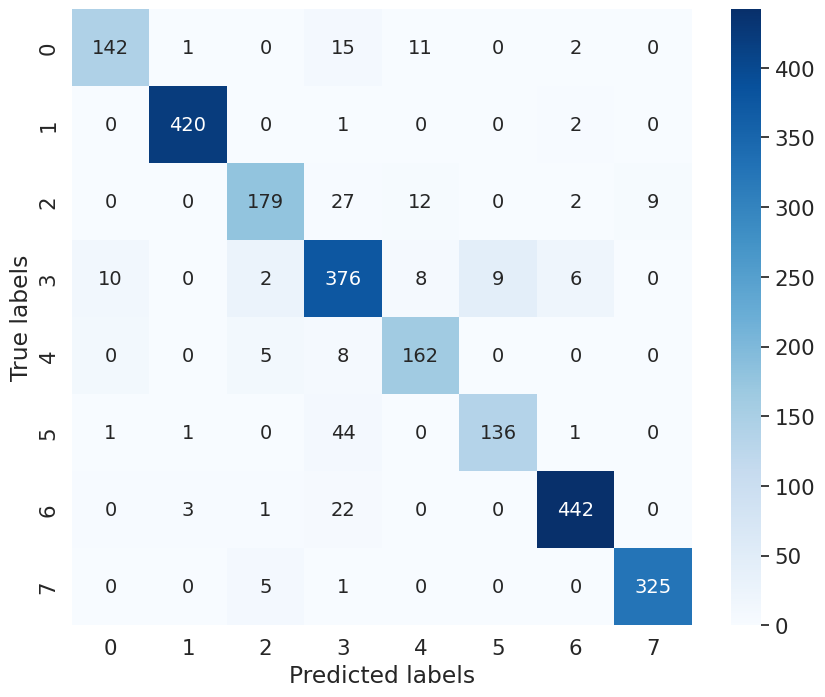

### VGG16

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

seed=42
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=lr_schedule,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Debug
    print("Output shape:", output_shape)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Optional: Apply augmentation if provided
    if augmentation:
        x = augmentation(input_layer)
    else:
        x = input_layer

    # Load the VGG16 model as the base model
    base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=(96,96,3),
    pooling=None,
    classifier_activation='softmax'
)

    # Add a global average pooling layer
    x = tfkl.GlobalAveragePooling2D(name='gap')(base_model.output)

    # Add a fully connected layer (optional)
   # x = tfkl.Dense(128, activation='relu', name='fc1')(x)

    # Add the output layer
    output_layer = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name='Vgg16_Custom')


    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)   # smoothing to prevent overfitting due to MixUp e CutMix
    #optimizer = tfk.optimizers.Adam(learning_rate)
    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

In [ ]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model)

In [ ]:
# Train the model with early stopping callback
#model.fit(augmented_data['images'], augmented_data['labels'], epochs=10, batch_size=32)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=normalized_class_weights
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGG16_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

del model

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Predictions of VGG16 model

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

### Xception

In [ ]:
# upload the model
# model = keras.models.load_model(model_filename)
model = tfk.models.load_model('TL_Xception_99.12.keras')

# make predictions
X_val = tf.image.resize(X_val, (299, 299))  # resize
X_val = X_val / 255.0  # normalizzazione
y_val = tfk.utils.to_categorical(y_val) # trasformo y_val in one-hot encoding
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

function to build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

seed=42
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=lr_schedule,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # check output shape for debug
    print("Output shape:", output_shape)

    # define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Optional: Apply augmentation if provided
    if augmentation:
        x = augmentation(input_layer)
    else:
        x = input_layer

    # initialize the estabilished pretrained backbone
    base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=(299, 299, 3),
    pooling=None,
    classifier_activation='softmax'
    )

    # add a global average pooling layer (needed it the features after the backbone are not in an array-like form)
    x = tfkl.GlobalAveragePooling2D(name='gap')(base_model.output)

    # output layer
    output_layer = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    # create the model
    model = Model(inputs=input_layer, outputs=output_layer, name='Xception_Custom')

    # define loss, optimizer, metrics to monitorate
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)   # smoothing to prevent overfitting due to MixUp e CutMix
    optimizer = tf.keras.optimizers.AdamW(learning_rate)
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)]

    # compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # return the compiled model
    return model

In [ ]:
# build the model
model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=lr_schedule, seed = 42)

# display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

freezing the first layers for fine tuning (if needed)

In [ ]:
# number of layers to freeze
N = 0

# set the first N layers as non-trainable
for i, layer in enumerate(model.layers[:N]):
    layer.trainable = False

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=normalized_class_weights
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_categorical_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_Xception_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)

# Free memory by deleting the model instance
del model

In [ ]:
Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - categorical_accuracy: 0.3175 - loss: 1.6446 - top_k_categorical_accuracy: 0.8111 - val_categorical_accuracy: 0.4797 - val_loss: 1.7436 - val_top_k_categorical_accuracy: 0.9724
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 299s 971ms/step - categorical_accuracy: 0.5015 - loss: 1.4202 - top_k_categorical_accuracy: 0.8741 - val_categorical_accuracy: 0.8904 - val_loss: 0.8201 - val_top_k_categorical_accuracy: 0.9954
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 299s 988ms/step - categorical_accuracy: 0.5293 - loss: 1.3724 - top_k_categorical_accuracy: 0.8856 - val_categorical_accuracy: 0.7921 - val_loss: 0.9772 - val_top_k_categorical_accuracy: 0.9987
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 299s 988ms/step - categorical_accuracy: 0.5402 - loss: 1.3540 - top_k_categorical_accuracy: 0.8914 - val_categorical_accuracy: 0.7520 - val_loss: 1.0482 - val_top_k_categorical_accuracy: 0.9958
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.5643 - loss: 1.3336 - top_k_categorical_accuracy: 0.8923 - val_categorical_accuracy: 0.9511 - val_loss: 0.8843 - val_top_k_categorical_accuracy: 0.9987
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 299s 989ms/step - categorical_accuracy: 0.5530 - loss: 1.3295 - top_k_categorical_accuracy: 0.8901 - val_categorical_accuracy: 0.9368 - val_loss: 0.8865 - val_top_k_categorical_accuracy: 0.9979
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 299s 988ms/step - categorical_accuracy: 0.5746 - loss: 1.3188 - top_k_categorical_accuracy: 0.8917 - val_categorical_accuracy: 0.9352 - val_loss: 0.7648 - val_top_k_categorical_accuracy: 0.9962
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.5749 - loss: 1.3156 - top_k_categorical_accuracy: 0.8931 - val_categorical_accuracy: 0.9293 - val_loss: 0.9053 - val_top_k_categorical_accuracy: 0.9971
Epoch 9/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.5849 - loss: 1.2808 - top_k_categorical_accuracy: 0.9085 - val_categorical_accuracy: 0.9017 - val_loss: 0.8942 - val_top_k_categorical_accuracy: 0.9958
Epoch 10/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.5697 - loss: 1.2875 - top_k_categorical_accuracy: 0.9043 - val_categorical_accuracy: 0.9544 - val_loss: 0.9174 - val_top_k_categorical_accuracy: 0.9996
Epoch 11/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.5768 - loss: 1.2888 - top_k_categorical_accuracy: 0.9044 - val_categorical_accuracy: 0.9218 - val_loss: 0.8641 - val_top_k_categorical_accuracy: 0.9992
Epoch 12/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.5910 - loss: 1.2622 - top_k_categorical_accuracy: 0.9119 - val_categorical_accuracy: 0.8846 - val_loss: 0.8904 - val_top_k_categorical_accuracy: 0.9987
Epoch 13/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.5736 - loss: 1.2724 - top_k_categorical_accuracy: 0.9103 - val_categorical_accuracy: 0.9519 - val_loss: 0.8034 - val_top_k_categorical_accuracy: 0.9996
Epoch 14/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.5825 - loss: 1.2562 - top_k_categorical_accuracy: 0.9126 - val_categorical_accuracy: 0.9578 - val_loss: 0.7723 - val_top_k_categorical_accuracy: 0.9996
Epoch 15/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.5763 - loss: 1.2660 - top_k_categorical_accuracy: 0.9162 - val_categorical_accuracy: 0.8770 - val_loss: 0.9309 - val_top_k_categorical_accuracy: 0.9987
Epoch 16/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.5865 - loss: 1.2408 - top_k_categorical_accuracy: 0.9190 - val_categorical_accuracy: 0.9272 - val_loss: 0.9006 - val_top_k_categorical_accuracy: 0.9987
Epoch 17/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.5831 - loss: 1.2361 - top_k_categorical_accuracy: 0.9228 - val_categorical_accuracy: 0.9155 - val_loss: 0.8618 - val_top_k_categorical_accuracy: 0.9983
Epoch 18/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 978ms/step - categorical_accuracy: 0.5900 - loss: 1.2118 - top_k_categorical_accuracy: 0.9295 - val_categorical_accuracy: 0.9665 - val_loss: 0.7851 - val_top_k_categorical_accuracy: 0.9996
Epoch 19/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.5965 - loss: 1.2085 - top_k_categorical_accuracy: 0.9252 - val_categorical_accuracy: 0.9373 - val_loss: 0.8646 - val_top_k_categorical_accuracy: 0.9975
Epoch 20/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.5893 - loss: 1.1977 - top_k_categorical_accuracy: 0.9295 - val_categorical_accuracy: 0.9762 - val_loss: 0.7859 - val_top_k_categorical_accuracy: 1.0000
Epoch 21/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 987ms/step - categorical_accuracy: 0.5965 - loss: 1.2085 - top_k_categorical_accuracy: 0.9251 - val_categorical_accuracy: 0.9716 - val_loss: 0.7951 - val_top_k_categorical_accuracy: 0.9996
Epoch 22/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.6009 - loss: 1.1944 - top_k_categorical_accuracy: 0.9162 - val_categorical_accuracy: 0.9728 - val_loss: 0.7738 - val_top_k_categorical_accuracy: 1.0000
Epoch 23/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.5997 - loss: 1.1979 - top_k_categorical_accuracy: 0.9214 - val_categorical_accuracy: 0.9368 - val_loss: 0.8994 - val_top_k_categorical_accuracy: 0.9996
Epoch 24/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.5979 - loss: 1.1836 - top_k_categorical_accuracy: 0.9291 - val_categorical_accuracy: 0.9034 - val_loss: 0.9168 - val_top_k_categorical_accuracy: 0.9967
Epoch 25/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6001 - loss: 1.1901 - top_k_categorical_accuracy: 0.9244 - val_categorical_accuracy: 0.9720 - val_loss: 0.8149 - val_top_k_categorical_accuracy: 0.9992
Epoch 26/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.5956 - loss: 1.1971 - top_k_categorical_accuracy: 0.9217 - val_categorical_accuracy: 0.9586 - val_loss: 0.8851 - val_top_k_categorical_accuracy: 0.9996
Epoch 27/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6080 - loss: 1.2030 - top_k_categorical_accuracy: 0.9189 - val_categorical_accuracy: 0.9674 - val_loss: 0.7752 - val_top_k_categorical_accuracy: 1.0000
Epoch 28/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.5996 - loss: 1.1863 - top_k_categorical_accuracy: 0.9255 - val_categorical_accuracy: 0.9770 - val_loss: 0.7541 - val_top_k_categorical_accuracy: 1.0000
Epoch 29/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.5971 - loss: 1.1917 - top_k_categorical_accuracy: 0.9303 - val_categorical_accuracy: 0.9803 - val_loss: 0.7546 - val_top_k_categorical_accuracy: 1.0000
Epoch 30/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.6009 - loss: 1.1868 - top_k_categorical_accuracy: 0.9266 - val_categorical_accuracy: 0.9741 - val_loss: 0.7558 - val_top_k_categorical_accuracy: 1.0000
Epoch 31/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6091 - loss: 1.1737 - top_k_categorical_accuracy: 0.9230 - val_categorical_accuracy: 0.9720 - val_loss: 0.7797 - val_top_k_categorical_accuracy: 0.9987
Epoch 32/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6051 - loss: 1.1900 - top_k_categorical_accuracy: 0.9226 - val_categorical_accuracy: 0.9762 - val_loss: 0.8528 - val_top_k_categorical_accuracy: 0.9996
Epoch 33/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 978ms/step - categorical_accuracy: 0.6053 - loss: 1.1502 - top_k_categorical_accuracy: 0.9385 - val_categorical_accuracy: 0.9816 - val_loss: 0.7249 - val_top_k_categorical_accuracy: 0.9996
Epoch 34/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6023 - loss: 1.1791 - top_k_categorical_accuracy: 0.9192 - val_categorical_accuracy: 0.9820 - val_loss: 0.7570 - val_top_k_categorical_accuracy: 1.0000
Epoch 35/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6018 - loss: 1.1565 - top_k_categorical_accuracy: 0.9327 - val_categorical_accuracy: 0.9737 - val_loss: 0.7747 - val_top_k_categorical_accuracy: 1.0000
Epoch 36/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6040 - loss: 1.1432 - top_k_categorical_accuracy: 0.9355 - val_categorical_accuracy: 0.9816 - val_loss: 0.7420 - val_top_k_categorical_accuracy: 1.0000
Epoch 37/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6087 - loss: 1.1358 - top_k_categorical_accuracy: 0.9375 - val_categorical_accuracy: 0.9820 - val_loss: 0.7698 - val_top_k_categorical_accuracy: 0.9992
Epoch 38/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.6116 - loss: 1.1337 - top_k_categorical_accuracy: 0.9360 - val_categorical_accuracy: 0.9791 - val_loss: 0.7277 - val_top_k_categorical_accuracy: 1.0000
Epoch 39/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.6013 - loss: 1.1520 - top_k_categorical_accuracy: 0.9305 - val_categorical_accuracy: 0.9845 - val_loss: 0.7641 - val_top_k_categorical_accuracy: 1.0000
Epoch 40/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6174 - loss: 1.1323 - top_k_categorical_accuracy: 0.9325 - val_categorical_accuracy: 0.9783 - val_loss: 0.8035 - val_top_k_categorical_accuracy: 0.9996
Epoch 41/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6009 - loss: 1.1479 - top_k_categorical_accuracy: 0.9319 - val_categorical_accuracy: 0.9845 - val_loss: 0.7503 - val_top_k_categorical_accuracy: 1.0000
Epoch 42/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6047 - loss: 1.1471 - top_k_categorical_accuracy: 0.9349 - val_categorical_accuracy: 0.9783 - val_loss: 0.6965 - val_top_k_categorical_accuracy: 1.0000
Epoch 43/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.6090 - loss: 1.1329 - top_k_categorical_accuracy: 0.9361 - val_categorical_accuracy: 0.9820 - val_loss: 0.7459 - val_top_k_categorical_accuracy: 1.0000
Epoch 44/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6148 - loss: 1.1104 - top_k_categorical_accuracy: 0.9413 - val_categorical_accuracy: 0.9849 - val_loss: 0.7334 - val_top_k_categorical_accuracy: 0.9996
Epoch 45/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.6101 - loss: 1.1244 - top_k_categorical_accuracy: 0.9389 - val_categorical_accuracy: 0.9833 - val_loss: 0.7655 - val_top_k_categorical_accuracy: 0.9996
Epoch 46/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.6052 - loss: 1.1374 - top_k_categorical_accuracy: 0.9358 - val_categorical_accuracy: 0.9812 - val_loss: 0.7511 - val_top_k_categorical_accuracy: 1.0000
Epoch 47/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6092 - loss: 1.1271 - top_k_categorical_accuracy: 0.9343 - val_categorical_accuracy: 0.9858 - val_loss: 0.7296 - val_top_k_categorical_accuracy: 1.0000
Epoch 48/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6181 - loss: 1.1269 - top_k_categorical_accuracy: 0.9308 - val_categorical_accuracy: 0.9854 - val_loss: 0.6929 - val_top_k_categorical_accuracy: 1.0000
Epoch 49/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.6066 - loss: 1.1324 - top_k_categorical_accuracy: 0.9345 - val_categorical_accuracy: 0.9858 - val_loss: 0.7291 - val_top_k_categorical_accuracy: 0.9996
Epoch 50/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6097 - loss: 1.1131 - top_k_categorical_accuracy: 0.9379 - val_categorical_accuracy: 0.9858 - val_loss: 0.7018 - val_top_k_categorical_accuracy: 1.0000
Epoch 51/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6156 - loss: 1.1060 - top_k_categorical_accuracy: 0.9415 - val_categorical_accuracy: 0.9870 - val_loss: 0.7373 - val_top_k_categorical_accuracy: 1.0000
Epoch 52/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6204 - loss: 1.0994 - top_k_categorical_accuracy: 0.9413 - val_categorical_accuracy: 0.9858 - val_loss: 0.7522 - val_top_k_categorical_accuracy: 1.0000
Epoch 53/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6154 - loss: 1.0902 - top_k_categorical_accuracy: 0.9431 - val_categorical_accuracy: 0.9883 - val_loss: 0.7353 - val_top_k_categorical_accuracy: 1.0000
Epoch 54/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.6224 - loss: 1.0812 - top_k_categorical_accuracy: 0.9495 - val_categorical_accuracy: 0.9858 - val_loss: 0.7622 - val_top_k_categorical_accuracy: 0.9996
Epoch 55/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 976ms/step - categorical_accuracy: 0.6112 - loss: 1.1107 - top_k_categorical_accuracy: 0.9361 - val_categorical_accuracy: 0.9862 - val_loss: 0.7409 - val_top_k_categorical_accuracy: 1.0000
Epoch 56/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6219 - loss: 1.0989 - top_k_categorical_accuracy: 0.9430 - val_categorical_accuracy: 0.9875 - val_loss: 0.7011 - val_top_k_categorical_accuracy: 0.9996
Epoch 57/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6215 - loss: 1.0768 - top_k_categorical_accuracy: 0.9493 - val_categorical_accuracy: 0.9887 - val_loss: 0.7426 - val_top_k_categorical_accuracy: 0.9996
Epoch 58/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6186 - loss: 1.0891 - top_k_categorical_accuracy: 0.9426 - val_categorical_accuracy: 0.9854 - val_loss: 0.7498 - val_top_k_categorical_accuracy: 1.0000
Epoch 59/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6195 - loss: 1.0937 - top_k_categorical_accuracy: 0.9407 - val_categorical_accuracy: 0.9870 - val_loss: 0.7353 - val_top_k_categorical_accuracy: 1.0000
Epoch 60/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 977ms/step - categorical_accuracy: 0.6196 - loss: 1.0938 - top_k_categorical_accuracy: 0.9406 - val_categorical_accuracy: 0.9858 - val_loss: 0.7420 - val_top_k_categorical_accuracy: 0.9996
Epoch 61/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 977ms/step - categorical_accuracy: 0.6142 - loss: 1.0962 - top_k_categorical_accuracy: 0.9469 - val_categorical_accuracy: 0.9854 - val_loss: 0.7450 - val_top_k_categorical_accuracy: 0.9996
Epoch 62/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6119 - loss: 1.0828 - top_k_categorical_accuracy: 0.9494 - val_categorical_accuracy: 0.9879 - val_loss: 0.6911 - val_top_k_categorical_accuracy: 1.0000
Epoch 63/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 978ms/step - categorical_accuracy: 0.6222 - loss: 1.0821 - top_k_categorical_accuracy: 0.9466 - val_categorical_accuracy: 0.9883 - val_loss: 0.7107 - val_top_k_categorical_accuracy: 1.0000
Epoch 64/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6094 - loss: 1.0938 - top_k_categorical_accuracy: 0.9488 - val_categorical_accuracy: 0.9845 - val_loss: 0.7269 - val_top_k_categorical_accuracy: 0.9996
Epoch 65/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.6109 - loss: 1.1022 - top_k_categorical_accuracy: 0.9415 - val_categorical_accuracy: 0.9875 - val_loss: 0.7397 - val_top_k_categorical_accuracy: 1.0000
Epoch 66/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 975ms/step - categorical_accuracy: 0.6171 - loss: 1.0799 - top_k_categorical_accuracy: 0.9458 - val_categorical_accuracy: 0.9845 - val_loss: 0.7216 - val_top_k_categorical_accuracy: 1.0000
Epoch 67/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 978ms/step - categorical_accuracy: 0.6132 - loss: 1.0909 - top_k_categorical_accuracy: 0.9455 - val_categorical_accuracy: 0.9845 - val_loss: 0.7282 - val_top_k_categorical_accuracy: 1.0000
Epoch 68/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6330 - loss: 1.0622 - top_k_categorical_accuracy: 0.9503 - val_categorical_accuracy: 0.9883 - val_loss: 0.7160 - val_top_k_categorical_accuracy: 1.0000
Epoch 69/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.6144 - loss: 1.0701 - top_k_categorical_accuracy: 0.9531 - val_categorical_accuracy: 0.9891 - val_loss: 0.7377 - val_top_k_categorical_accuracy: 1.0000
Epoch 70/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6139 - loss: 1.0638 - top_k_categorical_accuracy: 0.9517 - val_categorical_accuracy: 0.9883 - val_loss: 0.7208 - val_top_k_categorical_accuracy: 1.0000
Epoch 71/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 975ms/step - categorical_accuracy: 0.6274 - loss: 1.0784 - top_k_categorical_accuracy: 0.9439 - val_categorical_accuracy: 0.9866 - val_loss: 0.7095 - val_top_k_categorical_accuracy: 1.0000
Epoch 72/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6257 - loss: 1.0625 - top_k_categorical_accuracy: 0.9455 - val_categorical_accuracy: 0.9916 - val_loss: 0.6978 - val_top_k_categorical_accuracy: 1.0000
Epoch 73/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 295s 978ms/step - categorical_accuracy: 0.6243 - loss: 1.0644 - top_k_categorical_accuracy: 0.9487 - val_categorical_accuracy: 0.9883 - val_loss: 0.6990 - val_top_k_categorical_accuracy: 1.0000
Epoch 74/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 981ms/step - categorical_accuracy: 0.6176 - loss: 1.0963 - top_k_categorical_accuracy: 0.9339 - val_categorical_accuracy: 0.9895 - val_loss: 0.6891 - val_top_k_categorical_accuracy: 1.0000
Epoch 75/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6187 - loss: 1.0752 - top_k_categorical_accuracy: 0.9483 - val_categorical_accuracy: 0.9858 - val_loss: 0.7449 - val_top_k_categorical_accuracy: 0.9996
Epoch 76/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 986ms/step - categorical_accuracy: 0.6199 - loss: 1.0553 - top_k_categorical_accuracy: 0.9508 - val_categorical_accuracy: 0.9879 - val_loss: 0.7163 - val_top_k_categorical_accuracy: 0.9996
Epoch 77/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.6201 - loss: 1.0690 - top_k_categorical_accuracy: 0.9456 - val_categorical_accuracy: 0.9862 - val_loss: 0.7175 - val_top_k_categorical_accuracy: 1.0000
Epoch 78/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.6266 - loss: 1.0708 - top_k_categorical_accuracy: 0.9388 - val_categorical_accuracy: 0.9875 - val_loss: 0.7216 - val_top_k_categorical_accuracy: 1.0000
Epoch 79/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6168 - loss: 1.0664 - top_k_categorical_accuracy: 0.9438 - val_categorical_accuracy: 0.9912 - val_loss: 0.6958 - val_top_k_categorical_accuracy: 0.9996
Epoch 80/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6282 - loss: 1.0562 - top_k_categorical_accuracy: 0.9468 - val_categorical_accuracy: 0.9858 - val_loss: 0.7051 - val_top_k_categorical_accuracy: 0.9996
Epoch 81/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6352 - loss: 1.0549 - top_k_categorical_accuracy: 0.9431 - val_categorical_accuracy: 0.9866 - val_loss: 0.6916 - val_top_k_categorical_accuracy: 0.9996
Epoch 82/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.6206 - loss: 1.0584 - top_k_categorical_accuracy: 0.9494 - val_categorical_accuracy: 0.9895 - val_loss: 0.6997 - val_top_k_categorical_accuracy: 0.9996
Epoch 83/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.6235 - loss: 1.0662 - top_k_categorical_accuracy: 0.9425 - val_categorical_accuracy: 0.9870 - val_loss: 0.6880 - val_top_k_categorical_accuracy: 1.0000
Epoch 84/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 985ms/step - categorical_accuracy: 0.6353 - loss: 1.0374 - top_k_categorical_accuracy: 0.9535 - val_categorical_accuracy: 0.9879 - val_loss: 0.6816 - val_top_k_categorical_accuracy: 0.9996
Epoch 85/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 984ms/step - categorical_accuracy: 0.6302 - loss: 1.0379 - top_k_categorical_accuracy: 0.9545 - val_categorical_accuracy: 0.9883 - val_loss: 0.6676 - val_top_k_categorical_accuracy: 0.9996
Epoch 86/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 298s 984ms/step - categorical_accuracy: 0.6335 - loss: 1.0512 - top_k_categorical_accuracy: 0.9517 - val_categorical_accuracy: 0.9891 - val_loss: 0.7111 - val_top_k_categorical_accuracy: 1.0000
Epoch 87/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6243 - loss: 1.0359 - top_k_categorical_accuracy: 0.9541 - val_categorical_accuracy: 0.9887 - val_loss: 0.7000 - val_top_k_categorical_accuracy: 0.9996
Epoch 88/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6455 - loss: 1.0315 - top_k_categorical_accuracy: 0.9463 - val_categorical_accuracy: 0.9875 - val_loss: 0.6751 - val_top_k_categorical_accuracy: 1.0000
Epoch 89/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 983ms/step - categorical_accuracy: 0.6315 - loss: 1.0421 - top_k_categorical_accuracy: 0.9479 - val_categorical_accuracy: 0.9883 - val_loss: 0.6865 - val_top_k_categorical_accuracy: 0.9996
Epoch 90/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 980ms/step - categorical_accuracy: 0.6389 - loss: 1.0259 - top_k_categorical_accuracy: 0.9519 - val_categorical_accuracy: 0.9866 - val_loss: 0.7148 - val_top_k_categorical_accuracy: 1.0000
Epoch 91/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 296s 979ms/step - categorical_accuracy: 0.6487 - loss: 1.0367 - top_k_categorical_accuracy: 0.9505 - val_categorical_accuracy: 0.9887 - val_loss: 0.6673 - val_top_k_categorical_accuracy: 1.0000
Epoch 92/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 982ms/step - categorical_accuracy: 0.6354 - loss: 1.0331 - top_k_categorical_accuracy: 0.9549 - val_categorical_accuracy: 0.9866 - val_loss: 0.6570 - val_top_k_categorical_accuracy: 0.9996
Final validation accuracy: 99.16%

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

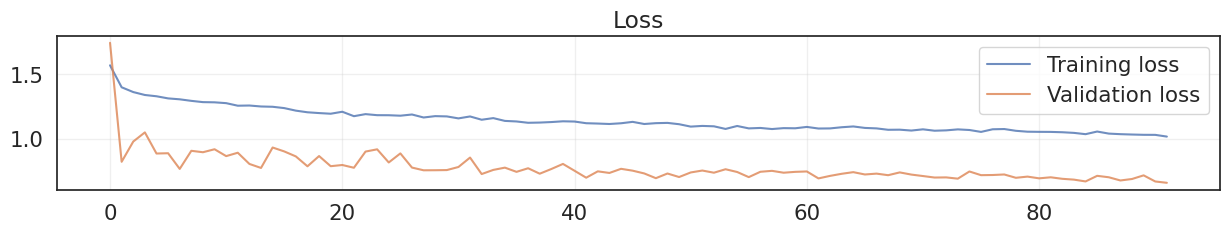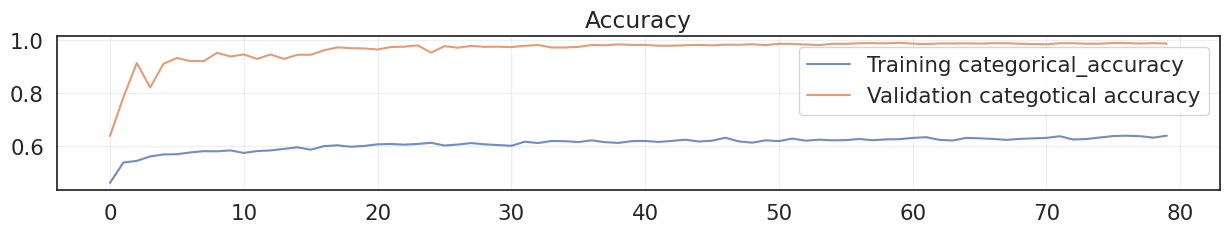

### EfficientNetB7

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

seed=42
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=lr_schedule,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Debug: Controlla l'output_shape passato
    print("Output shape:", output_shape)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Optional: Apply augmentation if provided
    if augmentation:
        x = augmentation(input_layer)
    else:
        x = input_layer

    base_model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=(96,96,3),
    pooling=None,
    classifier_activation='softmax'
    )

    # Add a global average pooling layer
    x = tfkl.GlobalAveragePooling2D(name='gap')(base_model.output)

    # Add the output layer
    output_layer = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name='Vgg16_Custom')


    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)   # smoothing to prevent overfitting due to MixUp e CutMix

    optimizer = tf.keras.optimizers.AdamW(learning_rate)
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

In [ ]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model,  show_shapes=True)

freezing the first layers for fine tuning (if needed)

In [ ]:
# number of layers to freeze
N = 0

# set the first N layers as non-trainable
for i, layer in enumerate(model.layers[:N]):
    layer.trainable = False

In [ ]:
# Train the model

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=normalized_class_weights
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'efficientnetB7.keras' #change this name based on the model
model.save(model_filename)

del model

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')



In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model = keras.models.load_model('efficientnetB7.keras')
X_val = (X_val).astype('float32')
y_val = tfk.utils.to_categorical(y_val)
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

### SE-ResNet50

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
import tensorflow.keras.backend as K


def squeeze_excite_block(tensor, ratio=8):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal, GlorotUniform


def bottleneck_block(x, filters, stride=1, se = False,):
    shortcut = x

    # Reduction of the number of channels with a 1x1 convolution
    x = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # main 3x3 convolution
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # channel expansion with a 1x1 convolution
    x = Conv2D(filters * 4, (1, 1), strides=1, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    if se:
      x = squeeze_excite_block(x)

    # matching the channel for the shortcut in the downsample layer
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=stride, padding='same', kernel_initializer=HeNormal())(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Sum and activation
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x



from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import SGD



def build_resnet(
    output_shape=8,
    learning_rate = learning_rate,
    augmentation=None,
    seed=42,
    layers = 50,
    se = False,
    dropout=False,
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Debug: checks the output shape
    if input_shape != (224,224,3):
      raise ValueError(f"input_shape must be (224, 224, 3), but got {input_shape} instead")
    print("Output shape:", output_shape)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # initial layers
    x = Conv2D(64, (7, 7), strides=2, padding='same',kernel_initializer=HeNormal())(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tfkl.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # define the structure for ResNet-50
    # each tupla (n, filters, stride) rappresents n blocks, each one with specific `filters` and `stride`

    if layers == 50:
        block_specs = [(3, 64, 1), (4, 128, 2), (6, 256, 2), (3, 512, 2)]
    elif layers == 101:
        block_specs = [(3, 64, 1), (4, 128, 2), (23, 256, 2), (3, 512, 2)]
    elif layers == 152:
        block_specs = [(3, 64, 1), (8, 128, 2), (36, 256, 2), (3, 512, 2)]
    else:
      raise ValueError("layers must 50, 101 or 152")

    # create the levels of ResNet-50
    for n_blocks, filters, stride in block_specs:
        for i in range(n_blocks):
            x = bottleneck_block(x, filters, stride if i == 0 else 1, se = se)
            if dropout:
              x = tf.keras.layers.SpatialDropout2D(0.1)(x)

    # final pooling finale and classification layer
    x = GlobalAveragePooling2D()(x)


    # Add the output layer
    output_layer = tfkl.Dense(output_shape, activation='softmax', name='Output',kernel_initializer=GlorotUniform())(x)
    model_name = f"ResNet{layers}" + ("_SE" if se else "")
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)  # Smoothing to prevent overfitting
    optimizer = tf.keras.optimizers.AdamW(learning_rate)
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False) to train as suggested in the original paper with lr= 0.1 with decay of 90% every 30 epochs
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model


In [ ]:
# Build the model with specified input and output shapes
model = build_resnet(layers = 50, se = True, dropout= True, learning_rate = 0.0001)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=normalized_class_weights
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Resnet'+str(final_val_accuracy)+'.keras' #change this name based on the model
model.save(model_filename)

del model

THE MODEL WAS TRAINED ON KAGGLE SO I COPIED ALL THE OUTPUT OF THE NOTEBOOK OF TRAINING AND EVALUATION BELOW


In [ ]:

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 208s 302ms/step - categorical_accuracy: 0.1211 - loss: 2.1407 - top_k_categorical_accuracy: 0.6493 - val_categorical_accuracy: 0.1384 - val_loss: 2.0668 - val_top_k_categorical_accuracy: 0.7788
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 216ms/step - categorical_accuracy: 0.1273 - loss: 1.9299 - top_k_categorical_accuracy: 0.6335 - val_categorical_accuracy: 0.1853 - val_loss: 2.0715 - val_top_k_categorical_accuracy: 0.6792
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 193ms/step - categorical_accuracy: 0.1215 - loss: 1.8779 - top_k_categorical_accuracy: 0.6359 - val_categorical_accuracy: 0.1585 - val_loss: 2.0723 - val_top_k_categorical_accuracy: 0.6692
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 196ms/step - categorical_accuracy: 0.1357 - loss: 1.8310 - top_k_categorical_accuracy: 0.6715 - val_categorical_accuracy: 0.2212 - val_loss: 1.8513 - val_top_k_categorical_accuracy: 0.9544
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.1624 - loss: 1.8041 - top_k_categorical_accuracy: 0.6990 - val_categorical_accuracy: 0.2087 - val_loss: 1.8377 - val_top_k_categorical_accuracy: 0.9519
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - categorical_accuracy: 0.1711 - loss: 1.7739 - top_k_categorical_accuracy: 0.7286 - val_categorical_accuracy: 0.1748 - val_loss: 1.8483 - val_top_k_categorical_accuracy: 0.9649
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - categorical_accuracy: 0.1775 - loss: 1.7583 - top_k_categorical_accuracy: 0.7376 - val_categorical_accuracy: 0.0770 - val_loss: 2.1125 - val_top_k_categorical_accuracy: 0.7323
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - categorical_accuracy: 0.1919 - loss: 1.7420 - top_k_categorical_accuracy: 0.7631 - val_categorical_accuracy: 0.2371 - val_loss: 1.8885 - val_top_k_categorical_accuracy: 0.8950
Epoch 9/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.2226 - loss: 1.7101 - top_k_categorical_accuracy: 0.7899 - val_categorical_accuracy: 0.1920 - val_loss: 1.9043 - val_top_k_categorical_accuracy: 0.8160
Epoch 10/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 192ms/step - categorical_accuracy: 0.2456 - loss: 1.7034 - top_k_categorical_accuracy: 0.7667 - val_categorical_accuracy: 0.2501 - val_loss: 1.9098 - val_top_k_categorical_accuracy: 0.7896
Epoch 11/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.2495 - loss: 1.6972 - top_k_categorical_accuracy: 0.7853 - val_categorical_accuracy: 0.4115 - val_loss: 1.7113 - val_top_k_categorical_accuracy: 0.9611
Epoch 12/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 193ms/step - categorical_accuracy: 0.2730 - loss: 1.6815 - top_k_categorical_accuracy: 0.7910 - val_categorical_accuracy: 0.2857 - val_loss: 1.7820 - val_top_k_categorical_accuracy: 0.9469
Epoch 13/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.2626 - loss: 1.6711 - top_k_categorical_accuracy: 0.7955 - val_categorical_accuracy: 0.4956 - val_loss: 1.5470 - val_top_k_categorical_accuracy: 0.9875
Epoch 14/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.2835 - loss: 1.6600 - top_k_categorical_accuracy: 0.8068 - val_categorical_accuracy: 0.4626 - val_loss: 1.5661 - val_top_k_categorical_accuracy: 0.9695
Epoch 15/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - categorical_accuracy: 0.2806 - loss: 1.6553 - top_k_categorical_accuracy: 0.8053 - val_categorical_accuracy: 0.5169 - val_loss: 1.5222 - val_top_k_categorical_accuracy: 0.9816
Epoch 16/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.2949 - loss: 1.6267 - top_k_categorical_accuracy: 0.8260 - val_categorical_accuracy: 0.4078 - val_loss: 1.6437 - val_top_k_categorical_accuracy: 0.9506
Epoch 17/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - categorical_accuracy: 0.2975 - loss: 1.6387 - top_k_categorical_accuracy: 0.8106 - val_categorical_accuracy: 0.5082 - val_loss: 1.4556 - val_top_k_categorical_accuracy: 0.9916
Epoch 18/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - categorical_accuracy: 0.3153 - loss: 1.6223 - top_k_categorical_accuracy: 0.8236 - val_categorical_accuracy: 0.4454 - val_loss: 1.5796 - val_top_k_categorical_accuracy: 0.9770
Epoch 19/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.3152 - loss: 1.6145 - top_k_categorical_accuracy: 0.8252 - val_categorical_accuracy: 0.5274 - val_loss: 1.5109 - val_top_k_categorical_accuracy: 0.9774
Epoch 20/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.3298 - loss: 1.6246 - top_k_categorical_accuracy: 0.8092 - val_categorical_accuracy: 0.7449 - val_loss: 1.2690 - val_top_k_categorical_accuracy: 0.9958
Epoch 21/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 192ms/step - categorical_accuracy: 0.3402 - loss: 1.6095 - top_k_categorical_accuracy: 0.8133 - val_categorical_accuracy: 0.6303 - val_loss: 1.3818 - val_top_k_categorical_accuracy: 0.9900
Epoch 22/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.3459 - loss: 1.5956 - top_k_categorical_accuracy: 0.8194 - val_categorical_accuracy: 0.5701 - val_loss: 1.5085 - val_top_k_categorical_accuracy: 0.9624
Epoch 23/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - categorical_accuracy: 0.3639 - loss: 1.5783 - top_k_categorical_accuracy: 0.8311 - val_categorical_accuracy: 0.7407 - val_loss: 1.1849 - val_top_k_categorical_accuracy: 0.9929
Epoch 24/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.3724 - loss: 1.5650 - top_k_categorical_accuracy: 0.8293 - val_categorical_accuracy: 0.7403 - val_loss: 1.2136 - val_top_k_categorical_accuracy: 0.9916
Epoch 25/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.3650 - loss: 1.5686 - top_k_categorical_accuracy: 0.8365 - val_categorical_accuracy: 0.7566 - val_loss: 1.1195 - val_top_k_categorical_accuracy: 0.9979
Epoch 26/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.3772 - loss: 1.5620 - top_k_categorical_accuracy: 0.8313 - val_categorical_accuracy: 0.6420 - val_loss: 1.3723 - val_top_k_categorical_accuracy: 0.9808
Epoch 27/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - categorical_accuracy: 0.3763 - loss: 1.5656 - top_k_categorical_accuracy: 0.8317 - val_categorical_accuracy: 0.6880 - val_loss: 1.1796 - val_top_k_categorical_accuracy: 0.9895
Epoch 28/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 249ms/step - categorical_accuracy: 0.4039 - loss: 1.5284 - top_k_categorical_accuracy: 0.8415 - val_categorical_accuracy: 0.7992 - val_loss: 1.0060 - val_top_k_categorical_accuracy: 0.9958
Epoch 29/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - categorical_accuracy: 0.3985 - loss: 1.5380 - top_k_categorical_accuracy: 0.8341 - val_categorical_accuracy: 0.7909 - val_loss: 1.0665 - val_top_k_categorical_accuracy: 0.9941
Epoch 30/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.4128 - loss: 1.5068 - top_k_categorical_accuracy: 0.8475 - val_categorical_accuracy: 0.7616 - val_loss: 1.0932 - val_top_k_categorical_accuracy: 0.9937
Epoch 31/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - categorical_accuracy: 0.4183 - loss: 1.5124 - top_k_categorical_accuracy: 0.8472 - val_categorical_accuracy: 0.7913 - val_loss: 1.1275 - val_top_k_categorical_accuracy: 0.9941
Epoch 32/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - categorical_accuracy: 0.4133 - loss: 1.5153 - top_k_categorical_accuracy: 0.8394 - val_categorical_accuracy: 0.7900 - val_loss: 1.0160 - val_top_k_categorical_accuracy: 0.9979
Epoch 33/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.4219 - loss: 1.5099 - top_k_categorical_accuracy: 0.8473 - val_categorical_accuracy: 0.7562 - val_loss: 1.0963 - val_top_k_categorical_accuracy: 0.9921
Epoch 34/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 195ms/step - categorical_accuracy: 0.4239 - loss: 1.4985 - top_k_categorical_accuracy: 0.8497 - val_categorical_accuracy: 0.8373 - val_loss: 0.9081 - val_top_k_categorical_accuracy: 0.9987
Epoch 35/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - categorical_accuracy: 0.4283 - loss: 1.4892 - top_k_categorical_accuracy: 0.8538 - val_categorical_accuracy: 0.8398 - val_loss: 0.9222 - val_top_k_categorical_accuracy: 0.9946
Epoch 36/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - categorical_accuracy: 0.4349 - loss: 1.4936 - top_k_categorical_accuracy: 0.8455 - val_categorical_accuracy: 0.8532 - val_loss: 0.9098 - val_top_k_categorical_accuracy: 0.9987
Epoch 37/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.4415 - loss: 1.4839 - top_k_categorical_accuracy: 0.8518 - val_categorical_accuracy: 0.8176 - val_loss: 0.9594 - val_top_k_categorical_accuracy: 0.9967
Epoch 38/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.4456 - loss: 1.4920 - top_k_categorical_accuracy: 0.8502 - val_categorical_accuracy: 0.5997 - val_loss: 1.3800 - val_top_k_categorical_accuracy: 0.9569
Epoch 39/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.4560 - loss: 1.4839 - top_k_categorical_accuracy: 0.8496 - val_categorical_accuracy: 0.8532 - val_loss: 0.9327 - val_top_k_categorical_accuracy: 0.9975
Epoch 40/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.4485 - loss: 1.4653 - top_k_categorical_accuracy: 0.8481 - val_categorical_accuracy: 0.8678 - val_loss: 0.9634 - val_top_k_categorical_accuracy: 0.9929
Epoch 41/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 249ms/step - categorical_accuracy: 0.4591 - loss: 1.4568 - top_k_categorical_accuracy: 0.8578 - val_categorical_accuracy: 0.8628 - val_loss: 0.8767 - val_top_k_categorical_accuracy: 0.9992
Epoch 42/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.4564 - loss: 1.4613 - top_k_categorical_accuracy: 0.8560 - val_categorical_accuracy: 0.7445 - val_loss: 1.1217 - val_top_k_categorical_accuracy: 0.9812
Epoch 43/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.4616 - loss: 1.4435 - top_k_categorical_accuracy: 0.8634 - val_categorical_accuracy: 0.8557 - val_loss: 0.8980 - val_top_k_categorical_accuracy: 0.9946
Epoch 44/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.4554 - loss: 1.4691 - top_k_categorical_accuracy: 0.8504 - val_categorical_accuracy: 0.8135 - val_loss: 1.0174 - val_top_k_categorical_accuracy: 0.9983
Epoch 45/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.4647 - loss: 1.4556 - top_k_categorical_accuracy: 0.8524 - val_categorical_accuracy: 0.8628 - val_loss: 0.9155 - val_top_k_categorical_accuracy: 0.9992
Epoch 46/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - categorical_accuracy: 0.4729 - loss: 1.4490 - top_k_categorical_accuracy: 0.8573 - val_categorical_accuracy: 0.8954 - val_loss: 0.8683 - val_top_k_categorical_accuracy: 0.9950
Epoch 47/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.4877 - loss: 1.4336 - top_k_categorical_accuracy: 0.8493 - val_categorical_accuracy: 0.6558 - val_loss: 1.3458 - val_top_k_categorical_accuracy: 0.9728
Epoch 48/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.4763 - loss: 1.4449 - top_k_categorical_accuracy: 0.8615 - val_categorical_accuracy: 0.7369 - val_loss: 1.2256 - val_top_k_categorical_accuracy: 0.9829
Epoch 49/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.4718 - loss: 1.4447 - top_k_categorical_accuracy: 0.8620 - val_categorical_accuracy: 0.9138 - val_loss: 0.8296 - val_top_k_categorical_accuracy: 1.0000
Epoch 50/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - categorical_accuracy: 0.4770 - loss: 1.4388 - top_k_categorical_accuracy: 0.8544 - val_categorical_accuracy: 0.8804 - val_loss: 0.8470 - val_top_k_categorical_accuracy: 0.9996
Epoch 51/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - categorical_accuracy: 0.4851 - loss: 1.4278 - top_k_categorical_accuracy: 0.8612 - val_categorical_accuracy: 0.9147 - val_loss: 0.8591 - val_top_k_categorical_accuracy: 1.0000
Epoch 52/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - categorical_accuracy: 0.4812 - loss: 1.4431 - top_k_categorical_accuracy: 0.8505 - val_categorical_accuracy: 0.8720 - val_loss: 0.9630 - val_top_k_categorical_accuracy: 0.9950
Epoch 53/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.4852 - loss: 1.4149 - top_k_categorical_accuracy: 0.8566 - val_categorical_accuracy: 0.8904 - val_loss: 0.8727 - val_top_k_categorical_accuracy: 0.9996
Epoch 54/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.4951 - loss: 1.4202 - top_k_categorical_accuracy: 0.8644 - val_categorical_accuracy: 0.9017 - val_loss: 0.8370 - val_top_k_categorical_accuracy: 0.9971
Epoch 55/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 150s 249ms/step - categorical_accuracy: 0.4890 - loss: 1.4220 - top_k_categorical_accuracy: 0.8604 - val_categorical_accuracy: 0.8708 - val_loss: 0.8875 - val_top_k_categorical_accuracy: 0.9975
Epoch 56/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - categorical_accuracy: 0.4903 - loss: 1.4256 - top_k_categorical_accuracy: 0.8627 - val_categorical_accuracy: 0.9335 - val_loss: 0.8070 - val_top_k_categorical_accuracy: 0.9996
Epoch 57/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.4971 - loss: 1.4329 - top_k_categorical_accuracy: 0.8589 - val_categorical_accuracy: 0.9051 - val_loss: 0.8376 - val_top_k_categorical_accuracy: 0.9962
Epoch 58/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.5016 - loss: 1.4059 - top_k_categorical_accuracy: 0.8672 - val_categorical_accuracy: 0.9067 - val_loss: 0.8350 - val_top_k_categorical_accuracy: 0.9992
Epoch 59/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - categorical_accuracy: 0.4943 - loss: 1.4056 - top_k_categorical_accuracy: 0.8683 - val_categorical_accuracy: 0.7988 - val_loss: 1.0967 - val_top_k_categorical_accuracy: 0.9958
Epoch 60/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - categorical_accuracy: 0.4999 - loss: 1.4016 - top_k_categorical_accuracy: 0.8705 - val_categorical_accuracy: 0.8524 - val_loss: 0.9657 - val_top_k_categorical_accuracy: 0.9950
Epoch 61/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 249ms/step - categorical_accuracy: 0.4998 - loss: 1.3975 - top_k_categorical_accuracy: 0.8672 - val_categorical_accuracy: 0.8110 - val_loss: 1.0171 - val_top_k_categorical_accuracy: 0.9925
Epoch 62/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - categorical_accuracy: 0.5022 - loss: 1.4032 - top_k_categorical_accuracy: 0.8709 - val_categorical_accuracy: 0.9260 - val_loss: 0.8140 - val_top_k_categorical_accuracy: 0.9987
Epoch 63/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 249ms/step - categorical_accuracy: 0.5118 - loss: 1.4006 - top_k_categorical_accuracy: 0.8623 - val_categorical_accuracy: 0.8745 - val_loss: 0.8939 - val_top_k_categorical_accuracy: 0.9950
Epoch 64/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 118s 193ms/step - categorical_accuracy: 0.5113 - loss: 1.4032 - top_k_categorical_accuracy: 0.8712 - val_categorical_accuracy: 0.8808 - val_loss: 0.8878 - val_top_k_categorical_accuracy: 0.9979
Epoch 65/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.5159 - loss: 1.3828 - top_k_categorical_accuracy: 0.8698 - val_categorical_accuracy: 0.9523 - val_loss: 0.7232 - val_top_k_categorical_accuracy: 0.9996
Epoch 66/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 152s 249ms/step - categorical_accuracy: 0.5167 - loss: 1.3907 - top_k_categorical_accuracy: 0.8766 - val_categorical_accuracy: 0.8921 - val_loss: 0.8990 - val_top_k_categorical_accuracy: 1.0000
Epoch 67/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.5207 - loss: 1.3885 - top_k_categorical_accuracy: 0.8761 - val_categorical_accuracy: 0.9210 - val_loss: 0.8175 - val_top_k_categorical_accuracy: 1.0000
Epoch 68/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 115s 191ms/step - categorical_accuracy: 0.5131 - loss: 1.3810 - top_k_categorical_accuracy: 0.8779 - val_categorical_accuracy: 0.7884 - val_loss: 1.0717 - val_top_k_categorical_accuracy: 0.9941
Epoch 69/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.5142 - loss: 1.3929 - top_k_categorical_accuracy: 0.8677 - val_categorical_accuracy: 0.9444 - val_loss: 0.8232 - val_top_k_categorical_accuracy: 0.9996
Epoch 70/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 250ms/step - categorical_accuracy: 0.5212 - loss: 1.3856 - top_k_categorical_accuracy: 0.8780 - val_categorical_accuracy: 0.9448 - val_loss: 0.7735 - val_top_k_categorical_accuracy: 0.9987
Epoch 71/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 192ms/step - categorical_accuracy: 0.5297 - loss: 1.3764 - top_k_categorical_accuracy: 0.8706 - val_categorical_accuracy: 0.8791 - val_loss: 0.8747 - val_top_k_categorical_accuracy: 0.9958
Epoch 72/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 151s 249ms/step - categorical_accuracy: 0.5225 - loss: 1.3786 - top_k_categorical_accuracy: 0.8752 - val_categorical_accuracy: 0.9260 - val_loss: 0.8246 - val_top_k_categorical_accuracy: 0.9992
Epoch 73/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 117s 192ms/step - categorical_accuracy: 0.5166 - loss: 1.3877 - top_k_categorical_accuracy: 0.8749 - val_categorical_accuracy: 0.9118 - val_loss: 0.8211 - val_top_k_categorical_accuracy: 0.9996
Epoch 74/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.5297 - loss: 1.3663 - top_k_categorical_accuracy: 0.8714 - val_categorical_accuracy: 0.8214 - val_loss: 0.9948 - val_top_k_categorical_accuracy: 0.9946
Epoch 75/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - categorical_accuracy: 0.5195 - loss: 1.3770 - top_k_categorical_accuracy: 0.8768 - val_categorical_accuracy: 0.9373 - val_loss: 0.7927 - val_top_k_categorical_accuracy: 1.0000
Epoch 76/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - categorical_accuracy: 0.5268 - loss: 1.3787 - top_k_categorical_accuracy: 0.8682 - val_categorical_accuracy: 0.9502 - val_loss: 0.7362 - val_top_k_categorical_accuracy: 0.9996
Epoch 77/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.5211 - loss: 1.3716 - top_k_categorical_accuracy: 0.8769 - val_categorical_accuracy: 0.9402 - val_loss: 0.7874 - val_top_k_categorical_accuracy: 1.0000
Epoch 78/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - categorical_accuracy: 0.5252 - loss: 1.3680 - top_k_categorical_accuracy: 0.8860 - val_categorical_accuracy: 0.9406 - val_loss: 0.7753 - val_top_k_categorical_accuracy: 1.0000
Epoch 79/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - categorical_accuracy: 0.5445 - loss: 1.3515 - top_k_categorical_accuracy: 0.8760 - val_categorical_accuracy: 0.9101 - val_loss: 0.8376 - val_top_k_categorical_accuracy: 0.9992
Epoch 80/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - categorical_accuracy: 0.5300 - loss: 1.3645 - top_k_categorical_accuracy: 0.8808 - val_categorical_accuracy: 0.9444 - val_loss: 0.7821 - val_top_k_categorical_accuracy: 1.0000
Final validation accuracy: 95.23%

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

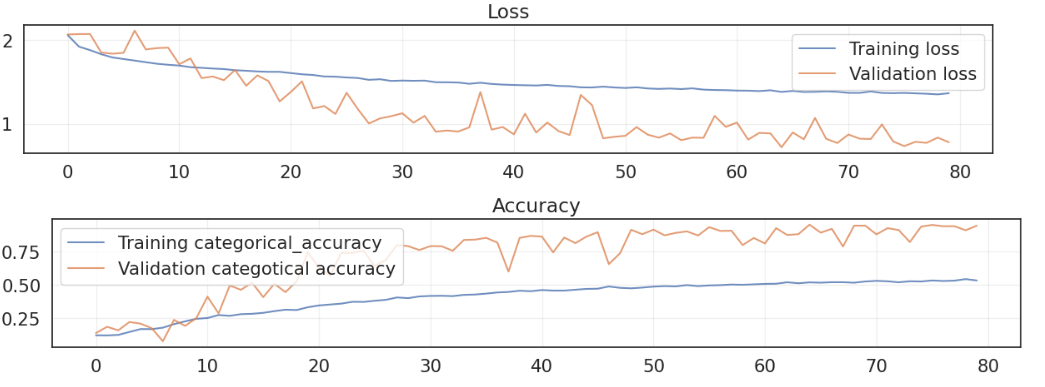

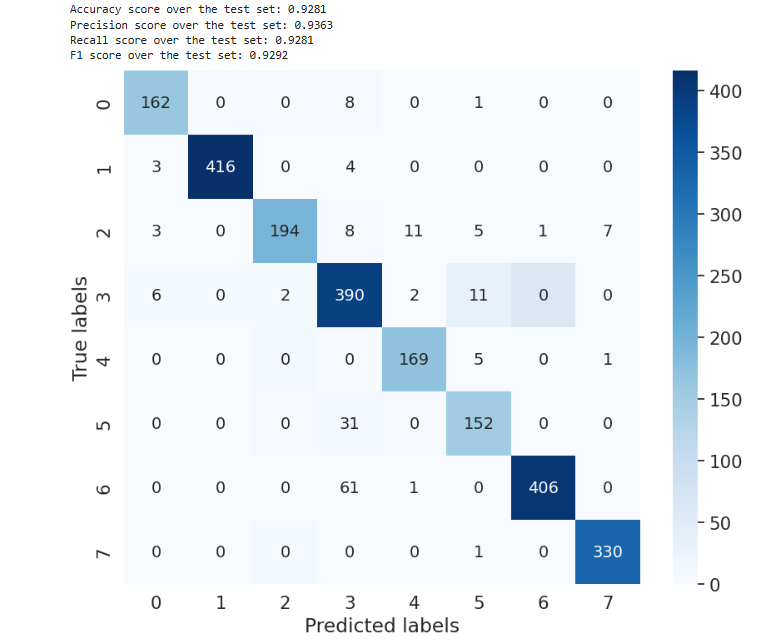

### ConVeXNetBase

In [ ]:
# Train the model with early stopping callback
#model.fit(augmented_data['images'], augmented_data['labels'], epochs=10, batch_size=32)
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=normalized_class_weights
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNextBase_'+str(final_val_accuracy)+'.keras' #change this name based on the model
model.save(model_filename)

del model

In [ ]:
Epoch 1/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - categorical_accuracy: 0.2596 - loss: 1.6929 - top_k_categorical_accuracy: 0.7659 - val_categorical_accuracy: 0.8361 - val_loss: 0.9782 - val_top_k_categorical_accuracy: 0.9967
Epoch 2/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - categorical_accuracy: 0.4776 - loss: 1.4635 - top_k_categorical_accuracy: 0.8634 - val_categorical_accuracy: 0.8988 - val_loss: 0.9017 - val_top_k_categorical_accuracy: 0.9992
Epoch 3/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.5173 - loss: 1.4116 - top_k_categorical_accuracy: 0.8714 - val_categorical_accuracy: 0.9456 - val_loss: 0.8306 - val_top_k_categorical_accuracy: 0.9992
Epoch 4/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.5349 - loss: 1.3692 - top_k_categorical_accuracy: 0.8872 - val_categorical_accuracy: 0.9582 - val_loss: 0.7759 - val_top_k_categorical_accuracy: 0.9996
Epoch 5/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5529 - loss: 1.3402 - top_k_categorical_accuracy: 0.8869 - val_categorical_accuracy: 0.9540 - val_loss: 0.8419 - val_top_k_categorical_accuracy: 0.9987
Epoch 6/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.5605 - loss: 1.3271 - top_k_categorical_accuracy: 0.8945 - val_categorical_accuracy: 0.9645 - val_loss: 0.7825 - val_top_k_categorical_accuracy: 0.9996
Epoch 7/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.5699 - loss: 1.3262 - top_k_categorical_accuracy: 0.8944 - val_categorical_accuracy: 0.9678 - val_loss: 0.7362 - val_top_k_categorical_accuracy: 1.0000
Epoch 8/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.5761 - loss: 1.3008 - top_k_categorical_accuracy: 0.9036 - val_categorical_accuracy: 0.9552 - val_loss: 0.8136 - val_top_k_categorical_accuracy: 1.0000
Epoch 9/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5869 - loss: 1.2483 - top_k_categorical_accuracy: 0.9188 - val_categorical_accuracy: 0.9628 - val_loss: 0.7436 - val_top_k_categorical_accuracy: 1.0000
Epoch 10/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5787 - loss: 1.2649 - top_k_categorical_accuracy: 0.9112 - val_categorical_accuracy: 0.9368 - val_loss: 0.8633 - val_top_k_categorical_accuracy: 1.0000
Epoch 11/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5797 - loss: 1.2521 - top_k_categorical_accuracy: 0.9161 - val_categorical_accuracy: 0.9720 - val_loss: 0.7766 - val_top_k_categorical_accuracy: 1.0000
Epoch 12/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5836 - loss: 1.2351 - top_k_categorical_accuracy: 0.9224 - val_categorical_accuracy: 0.9703 - val_loss: 0.8046 - val_top_k_categorical_accuracy: 1.0000
Epoch 13/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.5977 - loss: 1.2197 - top_k_categorical_accuracy: 0.9204 - val_categorical_accuracy: 0.9649 - val_loss: 0.8261 - val_top_k_categorical_accuracy: 1.0000
Epoch 14/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.5869 - loss: 1.2382 - top_k_categorical_accuracy: 0.9202 - val_categorical_accuracy: 0.9670 - val_loss: 0.8840 - val_top_k_categorical_accuracy: 1.0000
Epoch 15/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.5886 - loss: 1.2298 - top_k_categorical_accuracy: 0.9122 - val_categorical_accuracy: 0.9741 - val_loss: 0.7747 - val_top_k_categorical_accuracy: 1.0000
Epoch 16/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.5943 - loss: 1.1915 - top_k_categorical_accuracy: 0.9297 - val_categorical_accuracy: 0.9766 - val_loss: 0.8166 - val_top_k_categorical_accuracy: 1.0000
Epoch 17/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6013 - loss: 1.1978 - top_k_categorical_accuracy: 0.9208 - val_categorical_accuracy: 0.9820 - val_loss: 0.7823 - val_top_k_categorical_accuracy: 1.0000
Epoch 18/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6074 - loss: 1.1651 - top_k_categorical_accuracy: 0.9376 - val_categorical_accuracy: 0.9812 - val_loss: 0.7707 - val_top_k_categorical_accuracy: 1.0000
Epoch 19/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.5956 - loss: 1.1622 - top_k_categorical_accuracy: 0.9413 - val_categorical_accuracy: 0.9787 - val_loss: 0.8297 - val_top_k_categorical_accuracy: 1.0000
Epoch 20/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.5996 - loss: 1.1650 - top_k_categorical_accuracy: 0.9391 - val_categorical_accuracy: 0.9732 - val_loss: 0.8120 - val_top_k_categorical_accuracy: 1.0000
Epoch 21/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6089 - loss: 1.1644 - top_k_categorical_accuracy: 0.9282 - val_categorical_accuracy: 0.9795 - val_loss: 0.7885 - val_top_k_categorical_accuracy: 1.0000
Epoch 22/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.5953 - loss: 1.1676 - top_k_categorical_accuracy: 0.9340 - val_categorical_accuracy: 0.9770 - val_loss: 0.8251 - val_top_k_categorical_accuracy: 0.9992
Epoch 23/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.5999 - loss: 1.1835 - top_k_categorical_accuracy: 0.9263 - val_categorical_accuracy: 0.9787 - val_loss: 0.7582 - val_top_k_categorical_accuracy: 1.0000
Epoch 24/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6013 - loss: 1.1387 - top_k_categorical_accuracy: 0.9408 - val_categorical_accuracy: 0.9829 - val_loss: 0.7543 - val_top_k_categorical_accuracy: 1.0000
Epoch 25/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6052 - loss: 1.1509 - top_k_categorical_accuracy: 0.9314 - val_categorical_accuracy: 0.9795 - val_loss: 0.8114 - val_top_k_categorical_accuracy: 1.0000
Epoch 26/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.5987 - loss: 1.1558 - top_k_categorical_accuracy: 0.9276 - val_categorical_accuracy: 0.9841 - val_loss: 0.7545 - val_top_k_categorical_accuracy: 1.0000
Epoch 27/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6054 - loss: 1.1475 - top_k_categorical_accuracy: 0.9321 - val_categorical_accuracy: 0.9849 - val_loss: 0.8143 - val_top_k_categorical_accuracy: 0.9996
Epoch 28/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6080 - loss: 1.1514 - top_k_categorical_accuracy: 0.9353 - val_categorical_accuracy: 0.9820 - val_loss: 0.7332 - val_top_k_categorical_accuracy: 1.0000
Epoch 29/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6102 - loss: 1.1565 - top_k_categorical_accuracy: 0.9327 - val_categorical_accuracy: 0.9837 - val_loss: 0.7181 - val_top_k_categorical_accuracy: 1.0000
Epoch 30/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6057 - loss: 1.1241 - top_k_categorical_accuracy: 0.9421 - val_categorical_accuracy: 0.9820 - val_loss: 0.7910 - val_top_k_categorical_accuracy: 1.0000
Epoch 31/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6112 - loss: 1.1297 - top_k_categorical_accuracy: 0.9365 - val_categorical_accuracy: 0.9845 - val_loss: 0.7775 - val_top_k_categorical_accuracy: 1.0000
Epoch 32/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6136 - loss: 1.1196 - top_k_categorical_accuracy: 0.9373 - val_categorical_accuracy: 0.9866 - val_loss: 0.8029 - val_top_k_categorical_accuracy: 1.0000
Epoch 33/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - categorical_accuracy: 0.6073 - loss: 1.1077 - top_k_categorical_accuracy: 0.9434 - val_categorical_accuracy: 0.9841 - val_loss: 0.8322 - val_top_k_categorical_accuracy: 1.0000
Epoch 34/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - categorical_accuracy: 0.6165 - loss: 1.1087 - top_k_categorical_accuracy: 0.9431 - val_categorical_accuracy: 0.9837 - val_loss: 0.7632 - val_top_k_categorical_accuracy: 1.0000
Epoch 35/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - categorical_accuracy: 0.6054 - loss: 1.1287 - top_k_categorical_accuracy: 0.9399 - val_categorical_accuracy: 0.9837 - val_loss: 0.7545 - val_top_k_categorical_accuracy: 1.0000
Epoch 36/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6150 - loss: 1.1125 - top_k_categorical_accuracy: 0.9361 - val_categorical_accuracy: 0.9845 - val_loss: 0.7776 - val_top_k_categorical_accuracy: 1.0000
Epoch 37/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6117 - loss: 1.1001 - top_k_categorical_accuracy: 0.9439 - val_categorical_accuracy: 0.9841 - val_loss: 0.8056 - val_top_k_categorical_accuracy: 1.0000
Epoch 38/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6042 - loss: 1.1124 - top_k_categorical_accuracy: 0.9416 - val_categorical_accuracy: 0.9837 - val_loss: 0.7680 - val_top_k_categorical_accuracy: 1.0000
Epoch 39/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6202 - loss: 1.0990 - top_k_categorical_accuracy: 0.9422 - val_categorical_accuracy: 0.9824 - val_loss: 0.7410 - val_top_k_categorical_accuracy: 1.0000
Epoch 40/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6075 - loss: 1.1132 - top_k_categorical_accuracy: 0.9442 - val_categorical_accuracy: 0.9820 - val_loss: 0.8222 - val_top_k_categorical_accuracy: 1.0000
Epoch 41/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6127 - loss: 1.0966 - top_k_categorical_accuracy: 0.9479 - val_categorical_accuracy: 0.9841 - val_loss: 0.7620 - val_top_k_categorical_accuracy: 1.0000
Epoch 42/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - categorical_accuracy: 0.6175 - loss: 1.0821 - top_k_categorical_accuracy: 0.9465 - val_categorical_accuracy: 0.9837 - val_loss: 0.7891 - val_top_k_categorical_accuracy: 0.9996
Epoch 43/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6126 - loss: 1.1088 - top_k_categorical_accuracy: 0.9412 - val_categorical_accuracy: 0.9816 - val_loss: 0.7796 - val_top_k_categorical_accuracy: 1.0000
Epoch 44/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.6040 - loss: 1.0882 - top_k_categorical_accuracy: 0.9437 - val_categorical_accuracy: 0.9854 - val_loss: 0.7997 - val_top_k_categorical_accuracy: 1.0000
Epoch 45/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6125 - loss: 1.0958 - top_k_categorical_accuracy: 0.9434 - val_categorical_accuracy: 0.9854 - val_loss: 0.7580 - val_top_k_categorical_accuracy: 1.0000
Epoch 46/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6110 - loss: 1.0849 - top_k_categorical_accuracy: 0.9478 - val_categorical_accuracy: 0.9837 - val_loss: 0.8055 - val_top_k_categorical_accuracy: 1.0000
Epoch 47/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6097 - loss: 1.0891 - top_k_categorical_accuracy: 0.9433 - val_categorical_accuracy: 0.9887 - val_loss: 0.7836 - val_top_k_categorical_accuracy: 1.0000
Epoch 48/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6217 - loss: 1.0820 - top_k_categorical_accuracy: 0.9410 - val_categorical_accuracy: 0.9841 - val_loss: 0.8155 - val_top_k_categorical_accuracy: 0.9996
Epoch 49/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - categorical_accuracy: 0.6175 - loss: 1.0888 - top_k_categorical_accuracy: 0.9407 - val_categorical_accuracy: 0.9849 - val_loss: 0.7545 - val_top_k_categorical_accuracy: 1.0000
Epoch 50/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6174 - loss: 1.1039 - top_k_categorical_accuracy: 0.9368 - val_categorical_accuracy: 0.9833 - val_loss: 0.7760 - val_top_k_categorical_accuracy: 0.9996
Epoch 51/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6081 - loss: 1.1033 - top_k_categorical_accuracy: 0.9435 - val_categorical_accuracy: 0.9849 - val_loss: 0.7843 - val_top_k_categorical_accuracy: 1.0000
Epoch 52/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6191 - loss: 1.0796 - top_k_categorical_accuracy: 0.9471 - val_categorical_accuracy: 0.9845 - val_loss: 0.7876 - val_top_k_categorical_accuracy: 1.0000
Epoch 53/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - categorical_accuracy: 0.6055 - loss: 1.0802 - top_k_categorical_accuracy: 0.9520 - val_categorical_accuracy: 0.9803 - val_loss: 0.7823 - val_top_k_categorical_accuracy: 1.0000
Epoch 54/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6163 - loss: 1.0921 - top_k_categorical_accuracy: 0.9338 - val_categorical_accuracy: 0.9820 - val_loss: 0.7473 - val_top_k_categorical_accuracy: 1.0000
Epoch 55/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6160 - loss: 1.0907 - top_k_categorical_accuracy: 0.9385 - val_categorical_accuracy: 0.9849 - val_loss: 0.7566 - val_top_k_categorical_accuracy: 0.9996
Epoch 56/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6067 - loss: 1.0831 - top_k_categorical_accuracy: 0.9429 - val_categorical_accuracy: 0.9845 - val_loss: 0.7741 - val_top_k_categorical_accuracy: 1.0000
Epoch 57/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - categorical_accuracy: 0.6195 - loss: 1.0816 - top_k_categorical_accuracy: 0.9378 - val_categorical_accuracy: 0.9845 - val_loss: 0.7887 - val_top_k_categorical_accuracy: 0.9996
Epoch 58/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - categorical_accuracy: 0.6110 - loss: 1.0628 - top_k_categorical_accuracy: 0.9516 - val_categorical_accuracy: 0.9854 - val_loss: 0.7937 - val_top_k_categorical_accuracy: 0.9996
Epoch 59/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - categorical_accuracy: 0.6233 - loss: 1.0660 - top_k_categorical_accuracy: 0.9450 - val_categorical_accuracy: 0.9858 - val_loss: 0.7672 - val_top_k_categorical_accuracy: 1.0000
Epoch 60/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - categorical_accuracy: 0.6265 - loss: 1.0755 - top_k_categorical_accuracy: 0.9414 - val_categorical_accuracy: 0.9858 - val_loss: 0.7406 - val_top_k_categorical_accuracy: 1.0000
Epoch 61/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - categorical_accuracy: 0.6091 - loss: 1.0698 - top_k_categorical_accuracy: 0.9480 - val_categorical_accuracy: 0.9866 - val_loss: 0.7804 - val_top_k_categorical_accuracy: 1.0000
Epoch 62/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - categorical_accuracy: 0.6132 - loss: 1.0746 - top_k_categorical_accuracy: 0.9462 - val_categorical_accuracy: 0.9883 - val_loss: 0.7682 - val_top_k_categorical_accuracy: 1.0000
Final validation accuracy: 98.87%

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

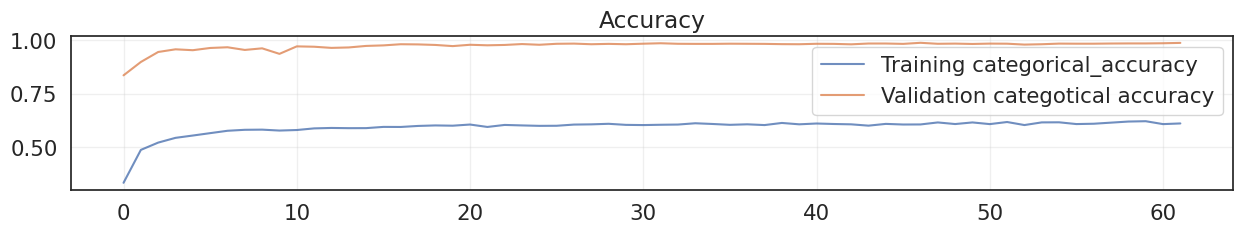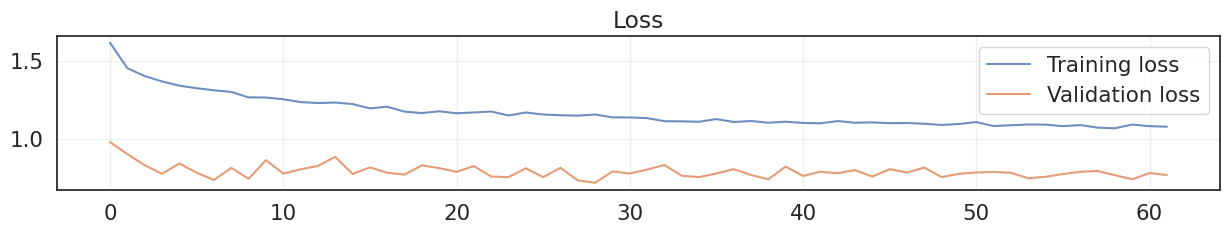

In [ ]:
model = keras.models.load_model(model_filename)
#model=keras.models.load_model('ConvNextBase_98.87.keras')
X_val = tf.image.resize(X_val, (224, 224))  # resize
y_val = tfk.utils.to_categorical(y_val)
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [ ]:
# i trained it on kaggle, so i report here the output that was print
Accuracy score over the test set: 0.9887
Precision score over the test set: 0.9888
Recall score over the test set: 0.9887
F1 score over the test set: 0.9887

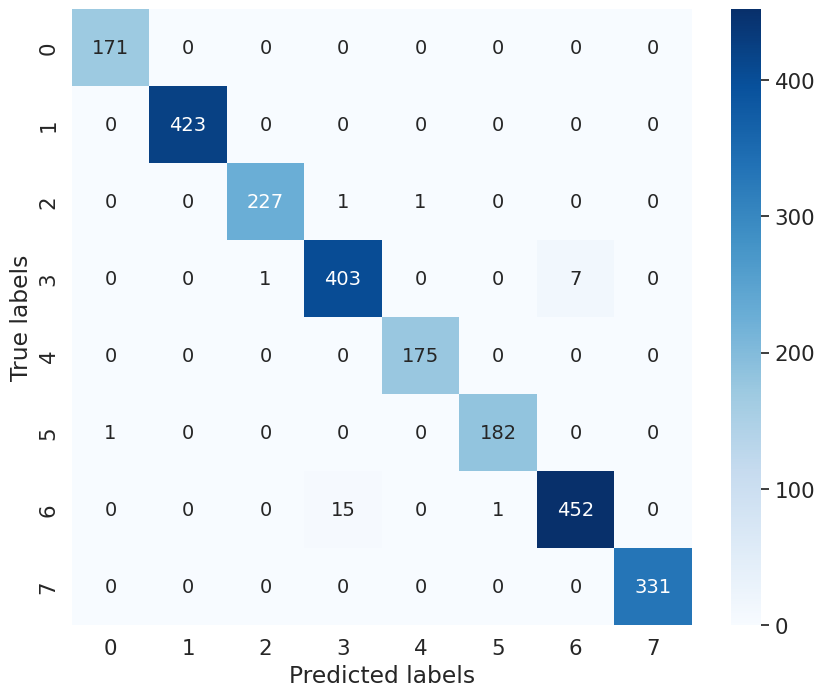

## 💭 Prediction

these are only the prediction of the best model (Xception)

In [ ]:
# upload the model
# model = keras.models.load_model(model_filename)
model = tfk.models.load_model('TL_Xception_99.12.keras')

# make predictions
X_val = tf.image.resize(X_val, (299, 299))  # resize
X_val = X_val / 255.0  # normalizzazione
y_val = tfk.utils.to_categorical(y_val) # trasformo y_val in one-hot encoding
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# extract ground truth classes
true_classes = np.argmax(y_val, axis=-1)

# calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

# Prepare the submission

In [ ]:
import shutil

# Definisci il percorso del file nel tuo Google Drive
drive_model_path = '/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/TL_Xception_99.12.keras'

# Definisci il percorso di destinazione in /content mantenendo il nome originale
content_model_path = '/content/TL_Xception_99.12.keras'

# Copia il modello da Google Drive a /content
shutil.copy(drive_model_path, content_model_path)

print("Modello copiato con successo!")

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        """
        self.neural_network = tfk.models.load_model('TL_Xception_99.12.keras') #insert here the name of your weights

    def predict(self, X, batch_size=32):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.
        """

        all_preds = []

        # for each batch
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]

            batch_resized = tf.image.resize(batch, (299, 299))  # Resize images to 299x299
            batch_resized = batch_resized / 255.0  # Normalize images

            # prediction for current batch
            preds = self.neural_network.predict(batch_resized)
            all_preds.append(preds)

        # concatenate all the predictions
        all_preds = np.concatenate(all_preds, axis=0)

        if len(all_preds.shape) == 2:
            all_preds = np.argmax(all_preds, axis=1)

        return all_preds

In [ ]:
from datetime import datetime
import os

# Create a name for the submission
filename = f'submission_test_models{model_filename}_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# specify model path
keras_file_path = model_filename

# add the files to zip file
if os.path.exists('model.py') and os.path.exists(keras_file_path):
    !zip {filename} model.py {keras_file_path}
else:
    print("Error, one or more files don't exist.")

# Import the librery for the download
from google.colab import files

# download the zip file
files.download(filename)